**Notebook 4-2-Fase 2** (v9)

Capa Silver (2): análisis de la correlación

Dataset: **2023/01**

Objetivos del presente notebook:
- Análisis de correlación, grupos A y B

Versiones:
- v1: código traspasado desde la v2 del notebook 3
- v2: estudio de la correlación, reducción de dimensionalidad y clustering
- v3: limpieza de v2 -> problemas de memoria, lo paso a v4
- v4: gestión de memoria: no funciona
- v5: vuelvo a v3, separo en fases
- v6: limpieza de v5; funciones comumes a otros notebooks pasadas a fichero .py
- v7: añado la fase 3
- v8: preparación de datos para Gold
- v9: limpieza de v8; acabado

In [1]:
import pyspark

from pyspark.sql import SparkSession

from google.colab import drive

import os
import sys
import gc
import json

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# directorio de los ficheros .py con funciones compartidas de la aplicación
sys.path.append("/content/drive/MyDrive/taxi_project")

In [5]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
SILVER_DIR = f"{PROJECT_ROOT}/silver"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"
SILVER_GOLD_DIR = f"{SILVER_DIR}/for_gold"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# crea directorios si no existen
paths = [BRONZE_DIR, SILVER_DIR, METADATA_DIR, SILVER_GOLD_DIR]

for path in paths:
    os.makedirs(path, exist_ok=True)

In [6]:
# dataset preparado para correlaciones
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_clean_251109"

In [7]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [8]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [9]:
from silver_functions_v3 import (
    get_bronze_dataset_paths, extract_year_month_from_hive_partition, format_date_info
)

In [10]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

In [11]:
# gestión de memoria
from silver_functions_v3 import show_memory_disk, clear_all_caches

In [12]:
# carga y guardado de ficheros
from silver_functions_v3 import save_parquet, load_parquet

In [13]:
# correlación
from silver_functions_v3 import (
    compute_correlation_matrix,
    analyze_correlation_group,
    calculate_correlation_summary,
    print_correlation_summary,
    plot_correlation_heatmap,
    identify_high_correlations_from_toplist,
    analyze_correlations
)

In [14]:
# Variance Inflation Factor (VIF)
from silver_functions_v3 import (
    calculate_vif, vif_to_pandas, filter_low_vif_variables, analyze_vif
)

In [15]:
# K-Means
from silver_functions_v3 import (
    silhouette_score_spark, plot_silhouette_scores, apply_kmeans_spark
)

In [16]:
# reducción de dimensionalidad
from silver_functions_v3 import calculate_dimensionality_reduction

In [17]:
# visualización de clustering
from silver_functions_v3 import (
    plot_clusters_2d, plot_cluster_profiles, plot_cluster_distribution,
    visualize_clusters_complete, plot_clusters_3d
)

In [18]:
# preparación de datos para Gold
from silver_functions_v3 import (
    generate_metadata, save_features_table, compute_quality_metrics,
    attach_correlations_to_quality_metrics, save_quality_metrics, compute_model_metrics,
    save_clusters_table, prepare_dimensionality_metrics, save_transformations_table
)

In [19]:
# logging y limpieza
from silver_functions_v3 import save_log_metrics, clear_memory

# **1) Carga del dataset: Enero de 2023 (2023-01)**

In [20]:
# lee dataframe en formato Parquet
ds_for_correlation_clean = load_parquet(spark, dir_dataset, mostrar_info=True)

if ds_for_correlation_clean is None:
    print("❌ El DataFrame no se ha cargado correctamente.")

📖 Leyendo DataFrame desde /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_clean_251109...
✅ Dataframe cargado correctamente
📊 Registros leídos: 3066715
📋 Columnas: 31
🏷️  Nombres de columnas: ['payment_type', 'pickup_hour', 'is_weekend', 'PULocationID_encoded', 'DOLocationID_encoded', 'passenger_count_encoded', 'RatecodeID_encoded', 'trip_distance_encoded', 'extra_encoded', 'tip_amount_encoded', 'improvement_surcharge_encoded', 'mta_tax_encoded', 'total_amount_encoded', 'trip_duration_minutes_encoded', 'average_speed_mph_encoded', 'fare_per_mile_encoded', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_dayofweek', 'tpep_pickup_datetime_dayofweek_sin', 'tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_cos', 'VendorID_encoded', 'store_and_fwd_flag_encoded', 'pickup_hour_hour_sin', 'pickup_hour_hour_cos', 'tip_score_encoded', 'trip_extra_c

# **3) Correlaciones internas críticas**

Vamos a identificar redundancias calculando correlaciones internas, multicolinealidad con VIF, agrupando variables similares y evaluando si una componente principal puede reemplazarlas.

**Separación de las variables en grupos**

Grupo A: Relación matemática directa

Grupo A-1: Variables de movimiento
- trip_distance_encoded
- trip_duration_minutes_encoded
- average_speed_mph_encoded

Grupo A-2: Variables tarifarias
- total_amount_encoded
- fare_per_mile_encoded
- tip_amount_encoded
- extra_encoded
- mta_tax_encoded
- improvement_surcharge_encoded

Grupo B: Redundancia temporal

Grupo B-1: Representaciones del día de la semana (inicio)
- tpep_pickup_datetime_dayofweek
- tpep_pickup_datetime_dayofweek_sin
- tpep_pickup_datetime_dayofweek_cos
- is_weekend

Grupo B-2: Representaciones de la hora (inicio)
- pickup_hour
- pickup_hour_hour_sin
- pickup_hour_hour_cos

Grupo B-3: Representaciones del día de la semana (final)
- tpep_dropoff_datetime_dayofweek
- tpep_dropoff_datetime_dayofweek_sin
- tpep_dropoff_datetime_dayofweek_cos

Grupo B-4: Correlación cruzada (inicio vs final)
- Todas las variables de pickup vs sus equivalentes de dropoff

Grupo C: Correlaciones contextuales

Grupo C-1: Variables de ubicación y tarifas
- PULocationID_encoded
- DOLocationID_encoded
- RatecodeID_encoded

Grupo C2: Variables de propinas
- tip_amount_encoded
- tip_score_encoded
- payment_type

Grupo C3: Variables de servicio
- passenger_count_encoded
- trip_distance_encoded
- trip_duration_minutes_encoded

Grupo C4: Variables técnicas/operativas
- store_and_fwd_flag_encoded
- VendorID_encoded

Grupo C-5: Correlaciones cruzadas contextuales entre ubicaciones y variables tarifarias
- PULocationID_encoded y RatecodeID_encoded
- DOLocationID_encoded y RatecodeID_encoded
- PULocationID_encoded y fare_per_mile_encoded
- DOLocationID_encoded y extra_encoded

Grupo C-6: Correlaciones cruzadas contextuales entre variables temporales y variables de servicio
- pickup_hour y passenger_count_encoded
- is_weekend y trip_distance_encoded
- tpep_pickup_datetime_dayofweek y average_speed_mph_encoded
- pickup_hour y toll_indicator_encoded

Grupo C-7: Correlaciones cruzadas contextuales entre variables de costo y variables de distancia/duración
- total_amount_encoded y trip_distance_encoded
- tip_amount_encoded y trip_duration_minutes_encoded
- fare_per_mile_encoded y average_speed_mph_encoded
- total_amount_encoded y trip_duration_minutes_encoded
- trip_extra_cost_ratio_encoded y average_speed_mph_encoded

## **Grupo A: Relación matemática directa**

### **Grupo A-1: Variables de movimiento**

Variables:

- trip_distance_encoded
- trip_duration_minutes_encoded
- average_speed_mph_encoded

In [21]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 1.52 GB / 13.61 GB (13.6%)
[Inicio limpieza completa de memoria] Disco usado: 42.47 GB / 115.66 GB (36.7%)


[Final limpieza completa de memoria] Memoria usada: 1.35 GB / 13.61 GB (12.4%)
[Final limpieza completa de memoria] Disco usado: 42.47 GB / 115.66 GB (36.7%)



In [22]:
grupo_a1 = [
    "trip_distance_encoded",
    "trip_duration_minutes_encoded",
    "average_speed_mph_encoded"
]

grupo_nombre = "A1 Variables de movimiento"

In [23]:
# gestión de metadatos
params = {
    "features": grupo_a1,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "A1 Variables de movimiento",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "trip_distance_encoded",
      "trip_duration_minutes_encoded",
      "average_speed_mph_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T15:44:24.446618",
  "model_version": "33eacd05e996",
  "featureset_version": "A1 Variables de movimiento_33eacd05e996",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [24]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_a1,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/a1_variables_de_movi__silver_features_20251110_154427.parquet
  Registros: 3,066,715
  Columnas: 8


In [25]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_a1,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - A1 VARIABLES DE MOVIMIENTO
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - A1 Variables de movimiento
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.128
Correlación máxima: 0.358
Correlación mínima: 0.013
Desviación estándar: 0.162

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 2 pares


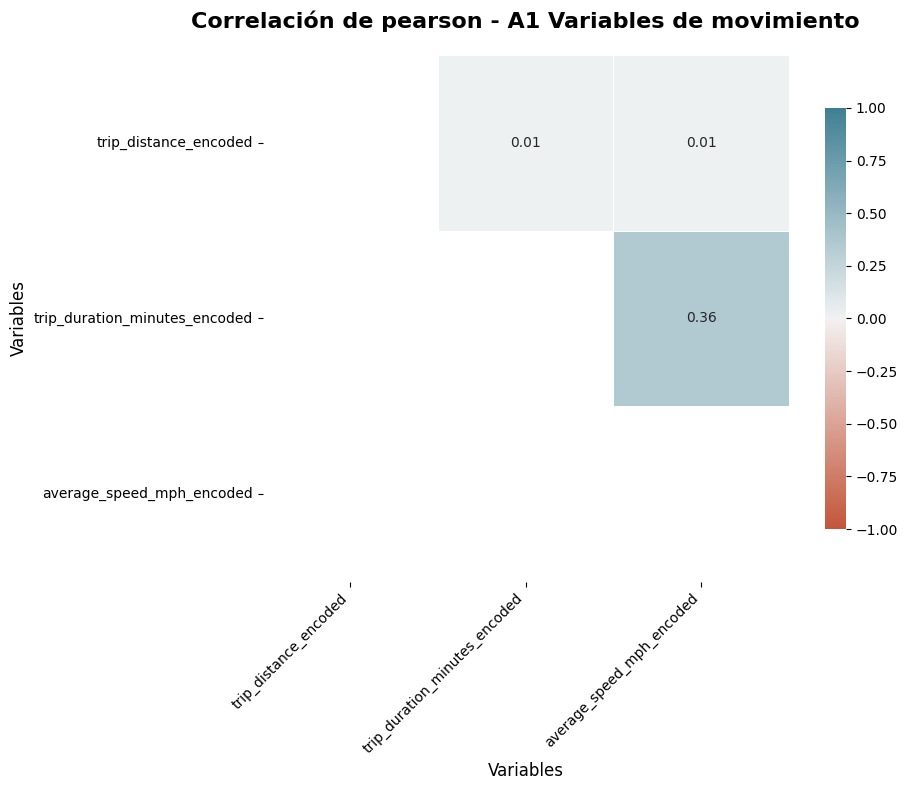


📊 ANÁLISIS DE CORRELACIÓN - A1 VARIABLES DE MOVIMIENTO
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - A1 Variables de movimiento
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.538
Correlación máxima: 0.862
Correlación mínima: 0.171
Desviación estándar: 0.284

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 1 pares


In [26]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_a1,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_a1,
    group_name = grupo_nombre,
    method = "spearman"
)

Correlación lineal moderada entre trip_duration_minutes y average_speed_mph.

Alta correlación no lineal entre trip_distance y trip_duration_minutes, y media entre trip_distance y average_speed_mph. Parece razonable que exista una alta relación entre la distancia y la duración del viaje, y cierta relación entre la velocidad media y la distancia y la duración (por ejemplo, viajes largos pueden utilizar más habitualmente vías rápidas).

In [27]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [28]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "A1 Variables de movimiento",
  "total_rows": 3066715,
  "variables": {
    "trip_distance_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.015504785875246022,
      "max": 1037.371977155861,
      "mean": -1.6782906439206588e-16,
      "median": -0.008333206947302121,
      "std": 0.9999999999999981,
      "q25": -0.011257929079927285,
      "q75": -0.002323503935058629,
      "n_outliers_iqr": 573232
    },
    "trip_duration_minutes_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.4157746634598511,
      "max": 4.115579432477305,
      "mean": 3.2286669690887127e-14,
      "median": -0.268072983028312,
      "std": 1.0000000000000036,
      "q25": -0.7091111833688162,
      "q75": 0.4051785121884425,
      "n_outliers_iqr": 440730
    },
    "average_speed_mph_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.817246358328

- **Análisis de VIF**

In [29]:
analyze_vif(ds_for_correlation_clean, grupo_a1)

                        Variable     VIF    Interpretacion
0  trip_duration_minutes_encoded  1.1469  Baja correlación
1      average_speed_mph_encoded  1.1468  Baja correlación
2          trip_distance_encoded  1.0003  Baja correlación

=== Variables con VIF aceptable ===



['trip_distance_encoded',
 'trip_duration_minutes_encoded',
 'average_speed_mph_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

No existe multicolinealidad para estas variables.

- **Clustering**

Vamos a aplicar en este caso PCA para reducir dimensionalidad y K-Means para clustering.

In [30]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_a1, num_clusters_a_probar)

plot_silhouette_scores(scores)

Para k = 2, la silueta media es: 0.7453
Para k = 3, la silueta media es: 0.7761
Para k = 4, la silueta media es: 0.7502
Para k = 5, la silueta media es: 0.5516
Para k = 6, la silueta media es: 0.5256
Para k = 7, la silueta media es: 0.5394
Para k = 8, la silueta media es: 0.5246


Para k = 2 tenemos clusters muy bien definidos, separables; k = 3 sería un poco mejor, pero a partir de k = 4 los clusters estarán menos definidos y habrá más solapamiento.

Por tanto, vamos a elegir k = 3.

In [31]:
k_optimo = 3

In [32]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_a1,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 3
- Variables utilizadas: ['trip_distance_encoded', 'trip_duration_minutes_encoded', 'average_speed_mph_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 3668096.2839

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |490429 |
|1      |2576282|
|2      |4      |
+-------+-------+


⏱️ Tiempo de ejecución: 73.14 segundos
📊 Balance de clusters - Min: 4,  Max: 2576282, Std: 1116965.52


Vemos que hay un cluster con muy pocos registros; son outliers de las variables del grupo estudiado, valores válidos pero que provocan la existencia de micro-clusters artificiales que no representan un grupo real.

In [33]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 3,
  "silhouette_score": 0.7760809566903407,
  "wssse": 3668096.2838911484,
  "cluster_sizes": [
    [
      1,
      2576282
    ],
    [
      2,
      4
    ],
    [
      0,
      490429
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7452773547899557,
    "3": 0.7760809566903407,
    "4": 0.7502001530494175,
    "5": 0.5516353597864907,
    "6": 0.5255998728698731,
    "7": 0.5393774495468838,
    "8": 0.5245611762452751
  },
  "centers": [
    [
      0.03503211301795814,
      1.5355411844928168,
      1.6838233742594402
    ],
    [
      -0.007896369862696234,
      -0.2923194870433362,
      -0.32054795612793524
    ],
    [
      790.4883292623681,
      -0.06425987529520025,
      0.0147667223843886
    ]
  ]
}


In [34]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/a1_variables_de_movi__silver_clusters_20251110_160908.parquet
  Registros: 3,066,715
  Clusters únicos: 3


- **Reducción de dimensionalidad**

In [35]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_a1, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [36]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


2. Perfiles de clusters...


3. Distribución de clusters...


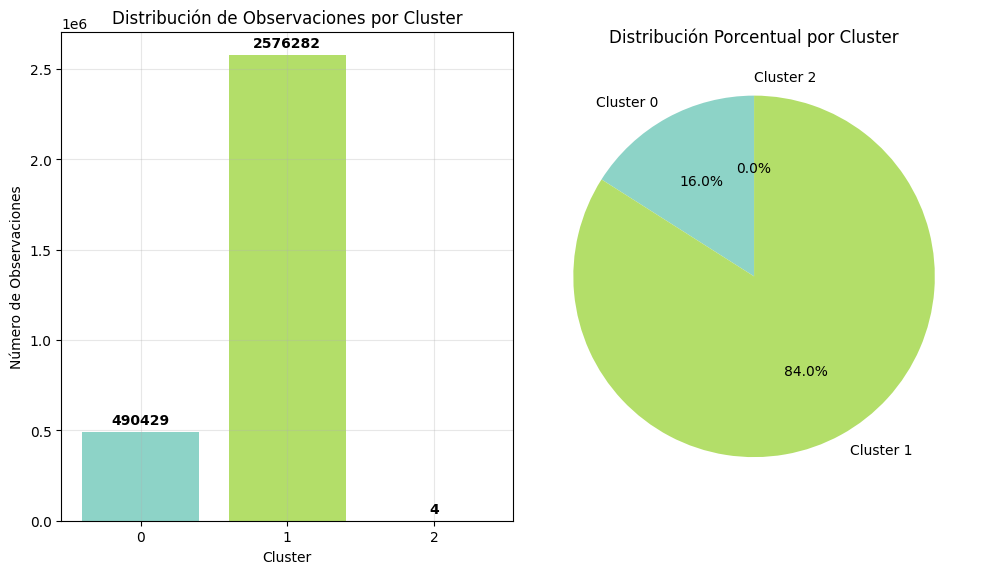

✅ Visualizaciones completadas!


In [37]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_a1,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

*Interpretación:*

PCA proporciona dos componentes principales que capturan el 100% de la varianza, PC1 casi el 70%.

Separación muy clara entre los dos grupos, especialmente en la dirección del componente principal PC1. El cluster 1, mayoritario, es más compacto que el 0, tiene valores medios bajos y negativos frente a los positivos y más altos del cluster 1 en 2 de las 3 variables (son muy similares en la tercera, trip_distance).

En resumen, separación muy clara de los dos grupos, uno de ellos mayoritario, más compacto y con valores medios más bajos en dos de las tres variables. El grupo con valores medios más bajos en duración y velocidad media indican viajes cortos y serían los más habituales; el grupo de valores medios más altos corresponde a viajes largos, más esporádicos.

In [38]:
# combina con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [39]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/a1_variables_de_movi__silver_transformations_pca_20251110_160933.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [40]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/a1_variables_de_movi__silver_logs_20251110_161319.parquet
  Total de registros en log: 1


In [41]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.26 GB / 13.61 GB (48.5%)
[Inicio] Disco usado: 42.61 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.26 GB / 13.61 GB (48.5%)
[Final] Disco usado: 42.61 GB / 115.66 GB (36.8%)



In [42]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.26 GB / 13.61 GB (48.5%)
[Inicio limpieza completa de memoria] Disco usado: 42.61 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.11 GB / 13.61 GB (17.9%)
[Final limpieza completa de memoria] Disco usado: 42.61 GB / 115.66 GB (36.8%)



### **Grupo A-2: Variables tarifarias**

In [43]:
grupo_a2 = [
    "total_amount_encoded",
    "fare_per_mile_encoded",
    "tip_amount_encoded",
    "extra_encoded",
    "mta_tax_encoded",
    "improvement_surcharge_encoded"
]

grupo_nombre = "A2 Variables tarifarias"

In [44]:
# gestión de metadatos
params = {
    "features": grupo_a2,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "A2 Variables tarifarias",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "total_amount_encoded",
      "fare_per_mile_encoded",
      "tip_amount_encoded",
      "extra_encoded",
      "mta_tax_encoded",
      "improvement_surcharge_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T16:13:34.485201",
  "model_version": "0736071a0842",
  "featureset_version": "A2 Variables tarifarias_0736071a0842",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [45]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_a2,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/a2_variables_tarifar__silver_features_20251110_161336.parquet
  Registros: 3,066,715
  Columnas: 11


In [46]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_a2,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - A2 VARIABLES TARIFARIAS
🔄 Calculando correlaciones de pearson para 6 variables...

📈 RESUMEN ESTADÍSTICO - A2 Variables tarifarias
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: -0.007
Correlación máxima: 0.715
Correlación mínima: -0.485
Desviación estándar: 0.261

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 2 pares
Bajo (|r| ≤ 0.3): 12 pares



📊 ANÁLISIS DE CORRELACIÓN - A2 VARIABLES TARIFARIAS
🔄 Calculando correlaciones de spearman para 6 variables...

📈 RESUMEN ESTADÍSTICO - A2 Variables tarifarias
--------------------------------------------------
Total de pares de variables: 15
Correlación promedio: -0.037
Correlación máxima: 0.584
Correlación mínima: -0.648
Desviación estándar: 0.259

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 4 pares
Bajo (|r| ≤ 0.3): 11 pares


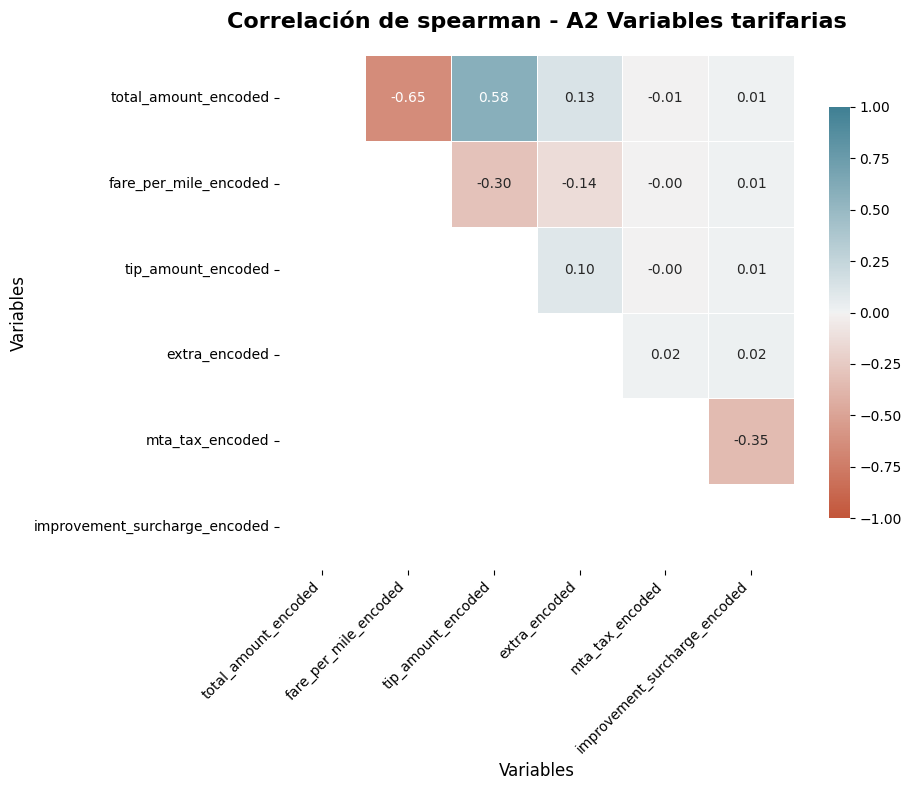

In [47]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_a2,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_a2,
    group_name = grupo_nombre,
    method = "spearman"
)

Alta correlación lineal entre total_amount y tip_amount, y moderada entre total_amount y fare_per_mile y entre fare_per_mile y tip_amount. Entre estas tres variables también hay correlación no lineal media. Es razonable la existencia de relación entre el importe total pagado, la propina y el importe base por milla. Estas relaciones son lógicas.

Además, hay correlación no lineal moderada entre mta_tax e improvement_surcharge. En este caso no parece tan evidente la relación entre el impuesto obligatorio y un recargo por mejoras del servicio.

In [48]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [49]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "A2 Variables tarifarias",
  "total_rows": 3066715,
  "variables": {
    "total_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.2660716187785135,
      "max": 52.80343867624831,
      "mean": 1.086146817348318e-14,
      "median": -0.33438874784170847,
      "std": 1.000000000000057,
      "q25": -0.5544785972540753,
      "q75": 0.046607125930960135,
      "n_outliers_iqr": 541814
    },
    "fare_per_mile_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -2.868975336736538,
      "max": 5.070273271175834,
      "mean": -1.3034152065937163e-13,
      "median": -0.1696446217696298,
      "std": 0.9999999999999712,
      "q25": -0.6920997782509958,
      "q75": 0.4871494942882729,
      "n_outliers_iqr": 390137
    },
    "tip_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.8805166318031237,
      "max": 98.66864

- **Análisis de VIF**

In [50]:
analyze_vif(ds_for_correlation_clean, grupo_a2)

                        Variable     VIF    Interpretacion
0           total_amount_encoded  2.4120  Baja correlación
1             tip_amount_encoded  2.0530  Baja correlación
2          fare_per_mile_encoded  1.3132  Baja correlación
3  improvement_surcharge_encoded  1.0804  Baja correlación
4                mta_tax_encoded  1.0800  Baja correlación
5                  extra_encoded  1.0486  Baja correlación

=== Variables con VIF aceptable ===



['total_amount_encoded',
 'fare_per_mile_encoded',
 'tip_amount_encoded',
 'extra_encoded',
 'mta_tax_encoded',
 'improvement_surcharge_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

No hay multicolinealidad en estas variables.

- **Clustering**

Para k = 2, la silueta media es: 0.7228
Para k = 3, la silueta media es: 0.7171
Para k = 4, la silueta media es: 0.7388
Para k = 5, la silueta media es: 0.3531
Para k = 6, la silueta media es: 0.3614
Para k = 7, la silueta media es: 0.4417
Para k = 8, la silueta media es: 0.3706


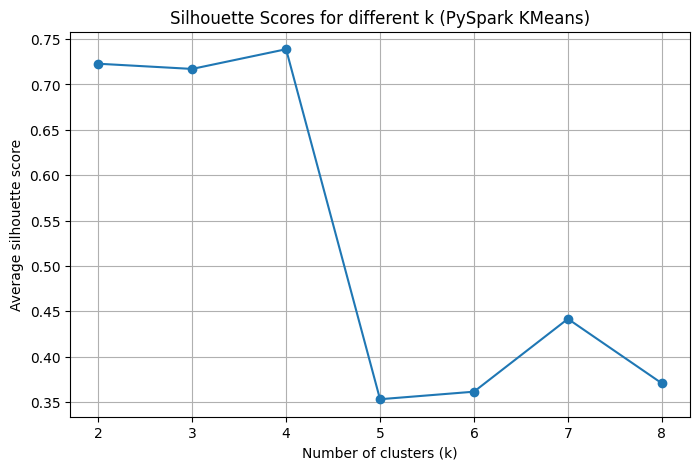

In [52]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_a2, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [54]:
k_optimo = 4

In [55]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_a2,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 4
- Variables utilizadas: ['total_amount_encoded', 'fare_per_mile_encoded', 'tip_amount_encoded', 'extra_encoded', 'mta_tax_encoded', 'improvement_surcharge_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 9255955.0254

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1910963|
|1      |269921 |
|2      |6226   |
|3      |879605 |
+-------+-------+


⏱️ Tiempo de ejecución: 89.31 segundos
📊 Balance de clusters - Min: 6226,  Max: 1910963, Std: 732665.58


In [56]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 4,
  "silhouette_score": 0.7387819422328453,
  "wssse": 9255955.025426267,
  "cluster_sizes": [
    [
      1,
      269921
    ],
    [
      3,
      879605
    ],
    [
      2,
      6226
    ],
    [
      0,
      1910963
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7228054092364176,
    "3": 0.717064581114311,
    "4": 0.7387819422328453,
    "5": 0.35310144600076654,
    "6": 0.3614038278064761,
    "7": 0.4416629155014026,
    "8": 0.3706372449374338
  },
  "centers": [
    [
      -0.11746666050906017,
      -0.394524859498391,
      -0.15040839021060648,
      -0.028780676634554532,
      -0.012870469953328398,
      0.044631009240804424
    ],
    [
      2.524695031334749,
      -1.1549410138137546,
      2.336143520897474,
      0.974285326422937,
      -0.013090318377232872,
      0.04448913885311078
    ],
    [
      -0.07940832962593633,
      -0.2012598991257257,
      -0.12451164208056732,
      -0.3856132440787089,
      6.333854992183663,
      

In [57]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/a2_variables_tarifar__silver_clusters_20251110_171557.parquet
  Registros: 3,066,715
  Clusters únicos: 4


- **Reducción de dimensionalidad**

In [58]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_a2, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [59]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

In [60]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/a2_variables_tarifar__silver_transformations_pca_20251110_171612.parquet
  Registros: 9,969
  Componentes: 2


In [61]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_a2, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


2. Perfiles de clusters...


3. Distribución de clusters...


✅ Visualizaciones completadas!


*Interpretación:*

Grupos aplanados en PC2: la estructura principal no es lineal y las dos primeras componentes no captan bien las relaciones.

Entre ambas componentes capturan menos del 60% de la varianza: PCA pierde información importante.

Vamos a aplicar t-SNE.

- **t-SNE**

In [62]:
# aplica t-SNE
ds_tsne, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_a2, method="tsne"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [63]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='tsne')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


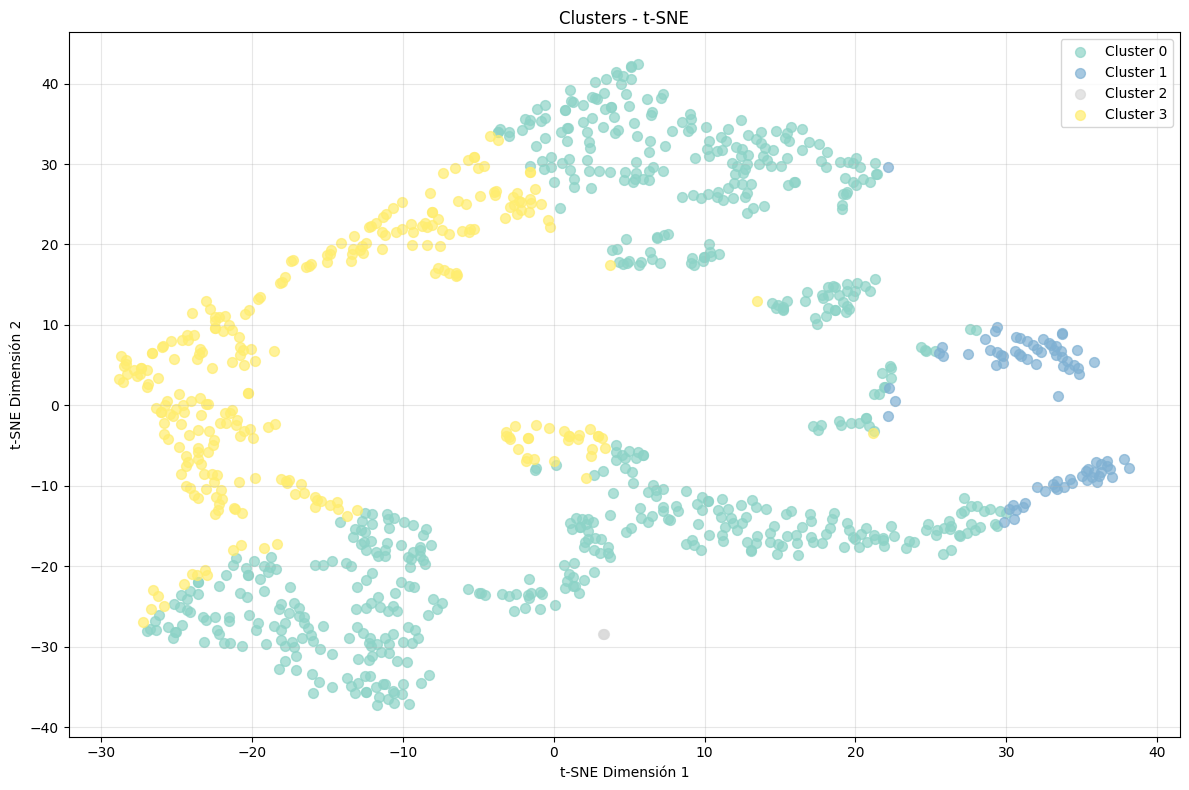

2. Perfiles de clusters...


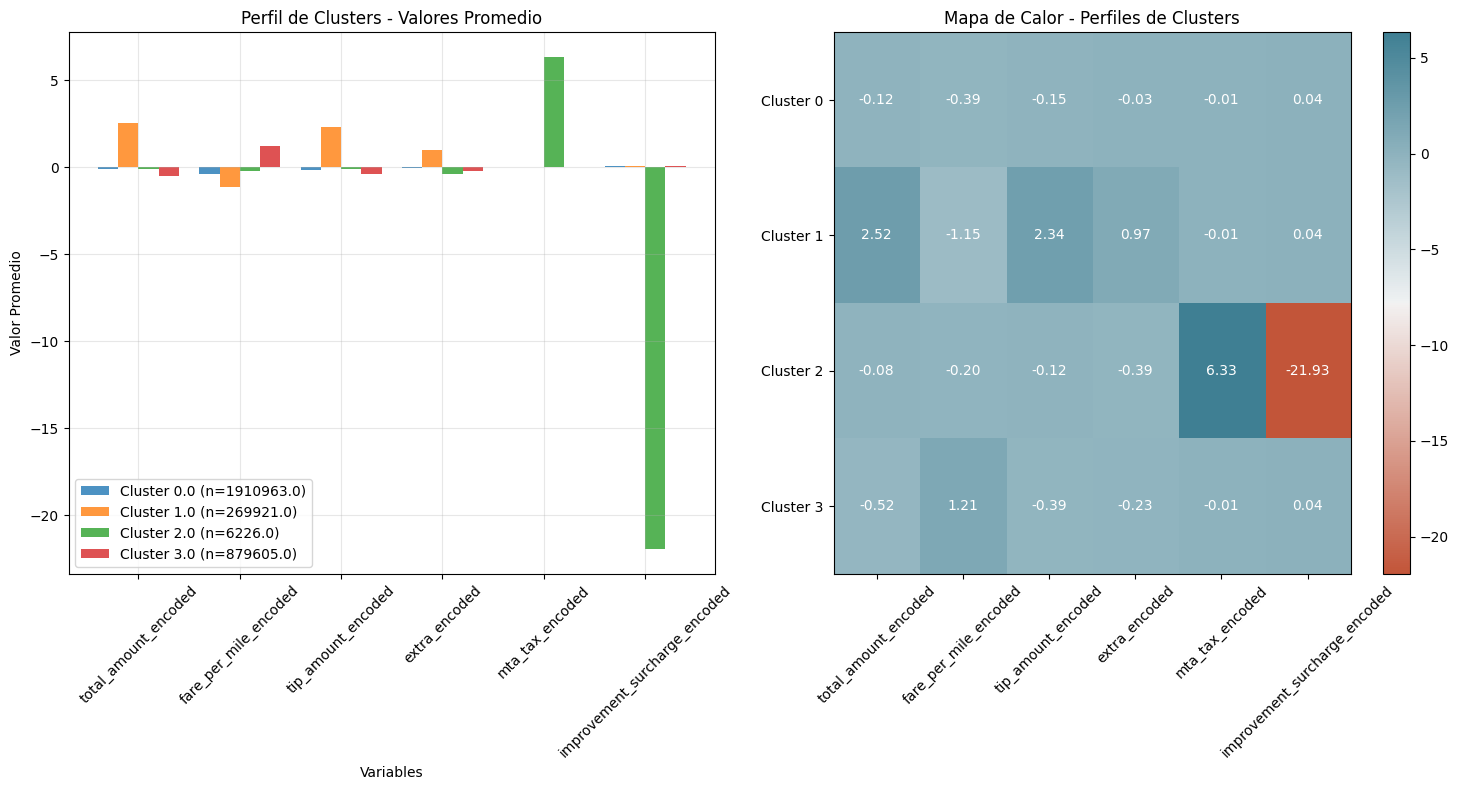

3. Distribución de clusters...


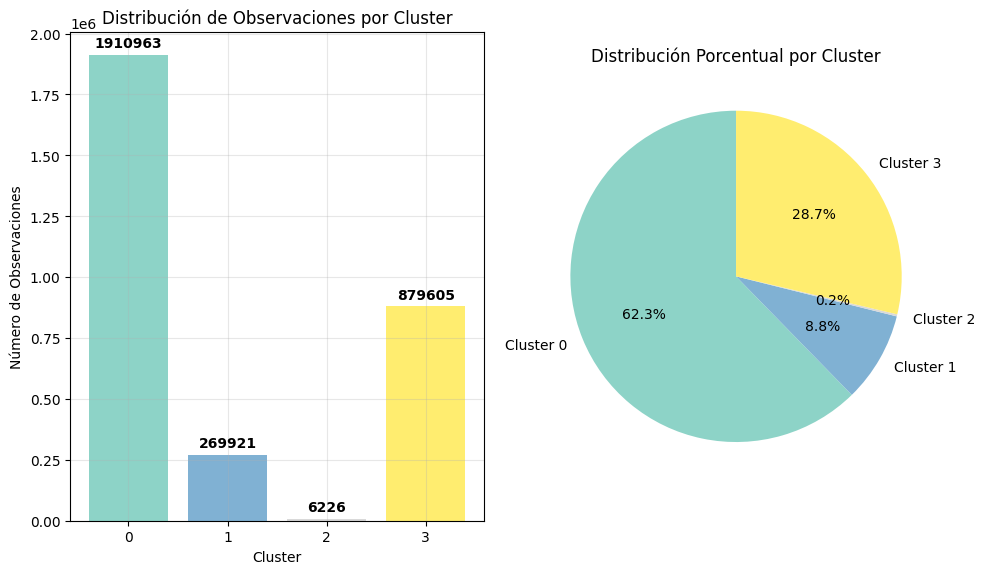

✅ Visualizaciones completadas!


In [64]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_a2,
    save_plots=False,
    method="tsne",
    ds_result=ds_tsne,
    method_info=method_info,
    sample_size=sample_size
)

Con t-SNE obtenemos cuatro grupos bien definidos y separados, confirmando la existencia de estructuras no lineales que PCA no lograba representar.

El cluster 2 es muy minoritario, entre los otros tres hay uno mayoritario (cluster 0), otro intermedio (3) y otro minoritario (1); el minoritario tiene valores mayores que los otros dos; en las variables mta_tax e improvement_surcharge no tienen variación entre los tres, y es en estas dos variables donde destaca el cluster 2, con valores muy elevados.

In [65]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [66]:
# guarda transformaciones t-SNE
filepath_tsne = save_transformations_table(
    ds_transformed=ds_tsne,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="tsne",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/a2_variables_tarifar__silver_transformations_tsne_20251110_171649.parquet
  Registros: 1,000
  Componentes: 2


- **Logging y limpieza**

In [67]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca,
    "tsne": filepath_tsne
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_tsne",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/a2_variables_tarifar__silver_logs_20251110_171800.parquet
  Total de registros en log: 1


In [68]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.50 GB / 13.61 GB (50.3%)
[Inicio] Disco usado: 42.67 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 6.50 GB / 13.61 GB (50.3%)
[Final] Disco usado: 42.67 GB / 115.66 GB (36.9%)



In [69]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.51 GB / 13.61 GB (50.3%)
[Inicio limpieza completa de memoria] Disco usado: 42.67 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.50 GB / 13.61 GB (20.8%)
[Final limpieza completa de memoria] Disco usado: 42.67 GB / 115.66 GB (36.9%)



## **Grupo B: Redundancia temporal**

### **Grupo B-1: Representaciones del día de la semana (inicio del trayecto)**

In [83]:
grupo_b1 = [
    "tpep_pickup_datetime_dayofweek",
    "tpep_pickup_datetime_dayofweek_sin",
    "tpep_pickup_datetime_dayofweek_cos",
    "is_weekend"
]

grupo_nombre = "B1 Representaciones del día de la semana (inicio)"

In [84]:
# gestión de metadatos
params = {
    "features": grupo_b1,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B1 Representaciones del d\u00eda de la semana (inicio)",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_dayofweek",
      "tpep_pickup_datetime_dayofweek_sin",
      "tpep_pickup_datetime_dayofweek_cos",
      "is_weekend"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T17:39:48.980056",
  "model_version": "b571e79b0737",
  "featureset_version": "B1 Representaciones del d\u00eda de la semana (inicio)_b571e79b0737",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [85]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b1,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b1_representaciones___silver_features_20251110_173950.parquet
  Registros: 3,066,715
  Columnas: 9


In [86]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b1,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - B1 REPRESENTACIONES DEL DÍA DE LA SEMANA (INICIO)
🔄 Calculando correlaciones de pearson para 4 variables...

📈 RESUMEN ESTADÍSTICO - B1 Representaciones del día de la semana (inicio)
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: -0.117
Correlación máxima: 0.737
Correlación mínima: -0.731
Desviación estándar: 0.454

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 2 pares
Moderado (0.3 < |r| ≤ 0.7): 2 pares
Bajo (|r| ≤ 0.3): 2 pares



📊 ANÁLISIS DE CORRELACIÓN - B1 REPRESENTACIONES DEL DÍA DE LA SEMANA (INICIO)
🔄 Calculando correlaciones de spearman para 4 variables...

📈 RESUMEN ESTADÍSTICO - B1 Representaciones del día de la semana (inicio)
--------------------------------------------------
Total de pares de variables: 6
Correlación promedio: -0.117
Correlación máxima: 0.644
Correlación mínima: -0.714
Desviación estándar: 0.458

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 2 pares


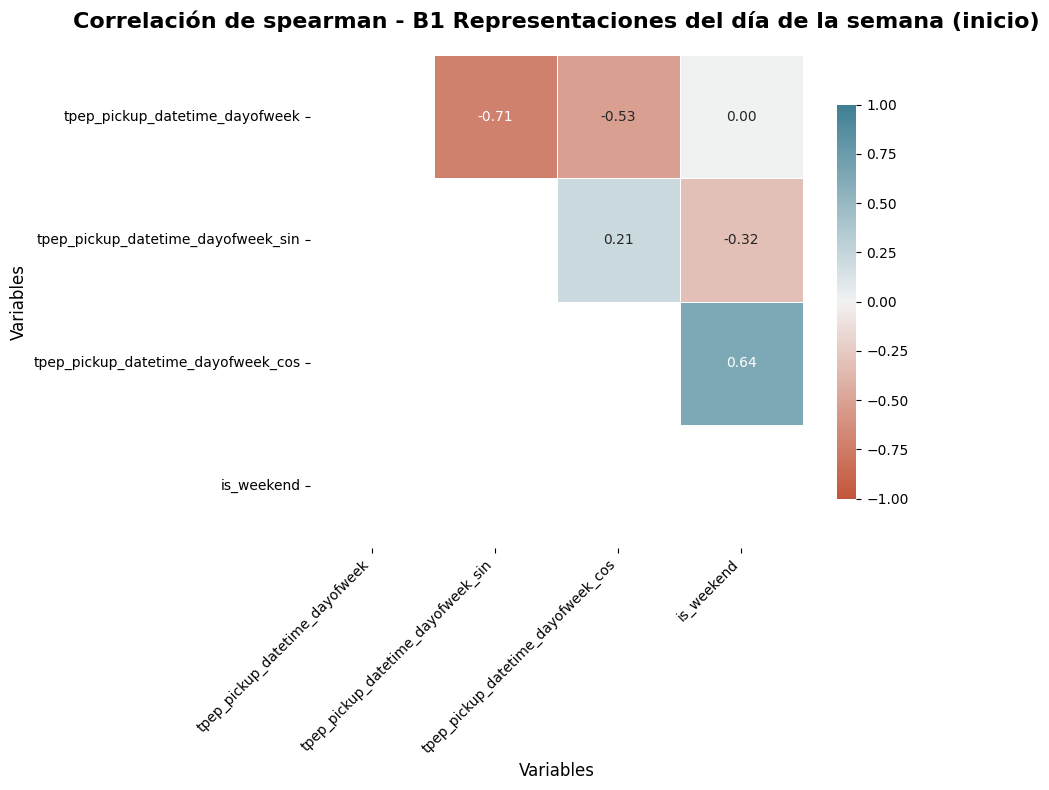

In [87]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b1,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b1,
    group_name = grupo_nombre,
    method = "spearman"
)

Alta correlación lineal entre tpep_pickup_datetime_dayofweek y tpep_pickup_datetime_dayofweek_sin, y entre tpep_pickup_datetime_dayofweek_cos e is_weekend; correlación lineal media entre tpep_pickup_datetime_dayofweek y tpep_pickup_datetime_dayofweek_cos y entre tpep_pickup_datetime_dayofweek_sin e is_weekend.

Correlación no lineal alta entre tpep_pickup_datetime_dayofweek y tpep_pickup_datetime_dayofweek_sin, y moderada entre tpep_pickup_datetime_dayofweek y tpep_pickup_datetime_dayofweek_cos, entre tpep_pickup_datetime_dayofweek_sin e is_weekend, y entre tpep_pickup_datetime_dayofweek_cos e is_weekend.

Todas estas variables son cálculos a partir de tpep_pickup_datetime, por lo que es normal encontrar tanta correlación entre ellas, responde a la relación matemática que las une.

In [88]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [89]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B1 Representaciones del d\u00eda de la semana (inicio)",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_dayofweek": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 7.0,
      "mean": 4.008377694047214,
      "median": 4.0,
      "std": 1.9938890811936483,
      "q25": 2.0,
      "q75": 6.0,
      "n_outliers_iqr": 0
    },
    "tpep_pickup_datetime_dayofweek_sin": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9749279121818236,
      "max": 0.9749279121818236,
      "mean": 0.0050148707835838665,
      "median": 0.0,
      "std": 0.7128735392183918,
      "q25": -0.7818314824680299,
      "q75": 0.7818314824680298,
      "n_outliers_iqr": 0
    },
    "tpep_pickup_datetime_dayofweek_cos": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9009688679024191,
      "max": 1.0,
      "mean": -0.004958095224509289,
     

- **Análisis de VIF**

In [90]:
analyze_vif(ds_for_correlation_clean, grupo_b1)

                             Variable     VIF    Interpretacion
0  tpep_pickup_datetime_dayofweek_cos  2.9567  Baja correlación
1                          is_weekend  2.9510  Baja correlación
2      tpep_pickup_datetime_dayofweek  2.9293  Baja correlación
3  tpep_pickup_datetime_dayofweek_sin  2.9245  Baja correlación

=== Variables con VIF aceptable ===



['tpep_pickup_datetime_dayofweek',
 'tpep_pickup_datetime_dayofweek_sin',
 'tpep_pickup_datetime_dayofweek_cos',
 'is_weekend']


=== Variables con VIF no aceptable (>= 10) ===



[]

No hay multicolinealidad en estas variables.

- **Clustering**

Para k = 2, la silueta media es: 0.7370
Para k = 3, la silueta media es: 0.6803
Para k = 4, la silueta media es: 0.6952
Para k = 5, la silueta media es: 0.6616
Para k = 6, la silueta media es: 0.8530
Para k = 7, la silueta media es: 1.0000
Para k = 8, la silueta media es: 1.0000


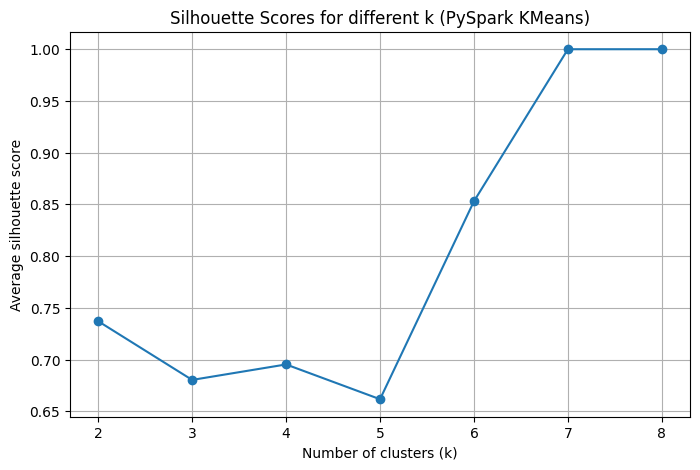

In [91]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b1, num_clusters_a_probar)

plot_silhouette_scores(scores)

Los valores de 7 y 8 clusters ofrecen un valor de silueta de 1. Los clusters para estos valores está completamente separados. Pero hay que tener en cuenta que las variables de este grupo hacen referencia a los días de la semana. Seguramente los 7 clusters correspondan a los 7 días de la semana, y los 8 clusters sean los 7 días de la semana más un cluster adicional (quizá para is_weekend = 1).

Por tanto, seguramente K-Means no aportará información útil, sólo validar que los 7 días de la semana generan 7 clusters.

In [92]:
k_optimo = 7

In [93]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b1,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 7
- Variables utilizadas: ['tpep_pickup_datetime_dayofweek', 'tpep_pickup_datetime_dayofweek_sin', 'tpep_pickup_datetime_dayofweek_cos', 'is_weekend']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 0.0000

Distribución de clusters:
+-------+------+
|cluster|count |
+-------+------+
|0      |436434|
|1      |434381|
|2      |441630|
|3      |416558|
|4      |404804|
|5      |441929|
|6      |490979|
+-------+------+


⏱️ Tiempo de ejecución: 59.43 segundos
📊 Balance de clusters - Min: 404804,  Max: 490979, Std: 25107.19


In [94]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 7,
  "silhouette_score": 1.0,
  "wssse": 0.0,
  "cluster_sizes": [
    [
      1,
      434381
    ],
    [
      6,
      490979
    ],
    [
      3,
      416558
    ],
    [
      5,
      441929
    ],
    [
      4,
      404804
    ],
    [
      2,
      441630
    ],
    [
      0,
      436434
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7370164514946459,
    "3": 0.6802740351262409,
    "4": 0.6952362100119268,
    "5": 0.6616103021305375,
    "6": 0.8530291813778919,
    "7": 1.0,
    "8": 1.0
  },
  "centers": [
    [
      1.0,
      0.0,
      1.0,
      1.0
    ],
    [
      6.0,
      -0.9749279121763016,
      -0.2225209339559405,
      0.0
    ],
    [
      7.0,
      -0.7818314824669028,
      0.6234898018578336,
      1.0
    ],
    [
      4.0,
      0.43388373911398576,
      -0.9009688678972796,
      0.0
    ],
    [
      2.0,
      0.7818314824653894,
      0.6234898018592279,
      0.0
    ],
    [
      5.0,
      -0.43388373911384187,


In [95]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b1_representaciones___silver_clusters_20251110_175408.parquet
  Registros: 3,066,715
  Clusters únicos: 7


- **Reducción de dimensionalidad**

In [96]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b1, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [97]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


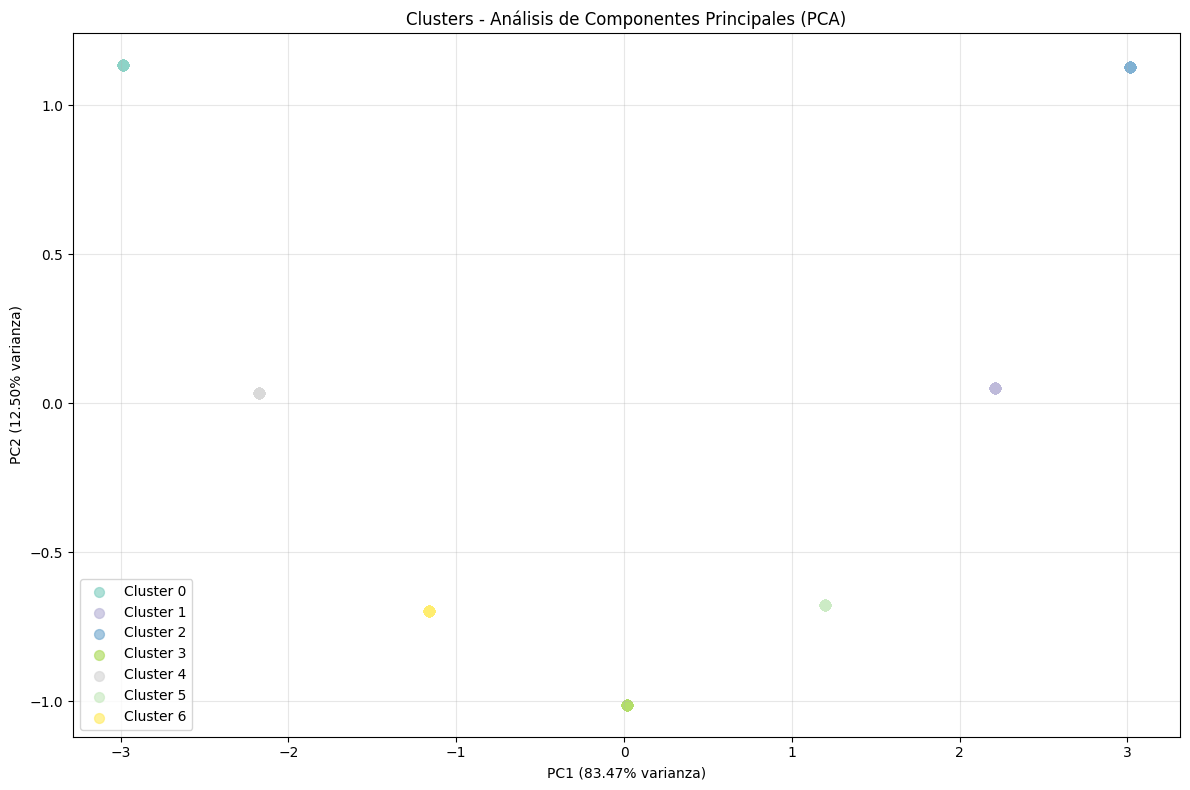

2. Perfiles de clusters...


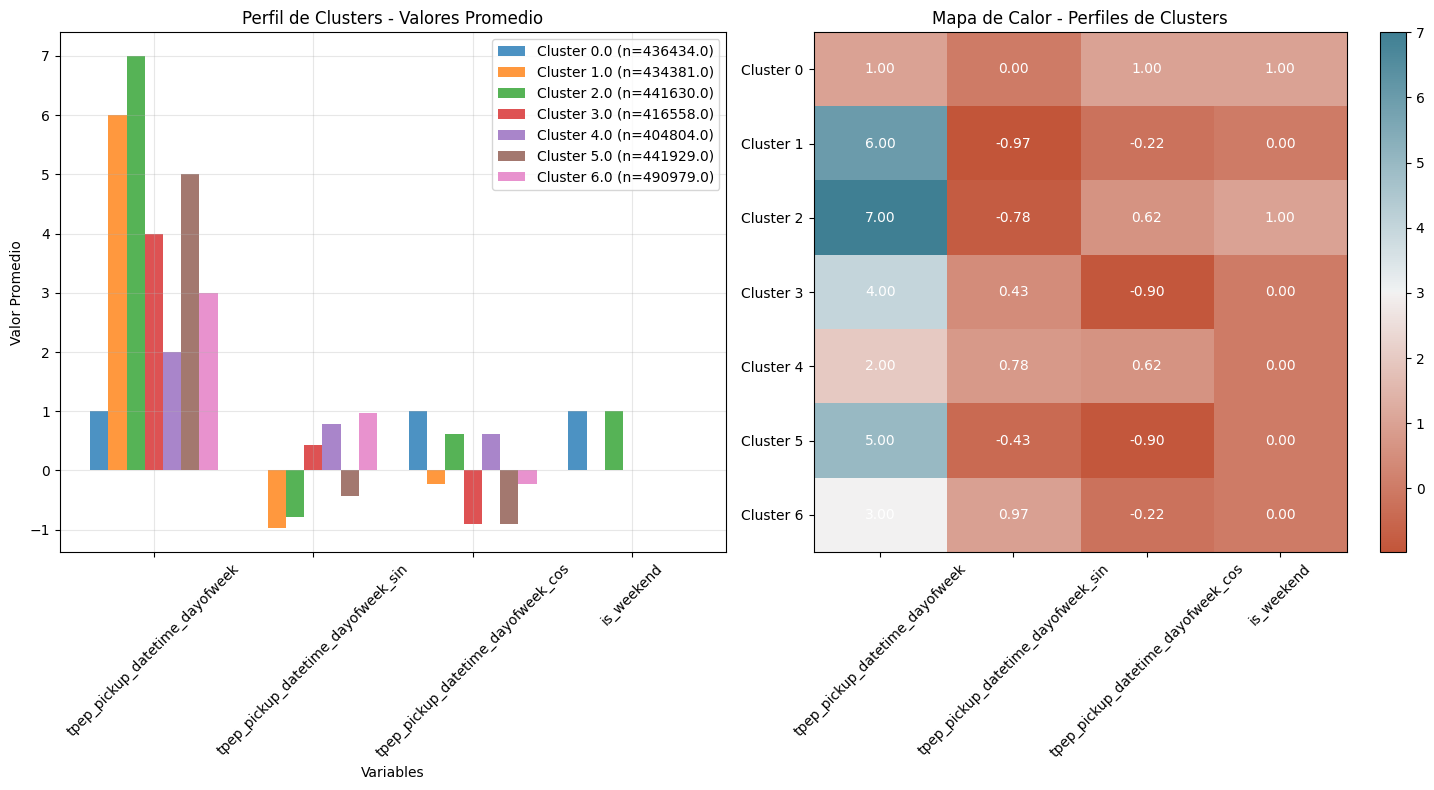

3. Distribución de clusters...


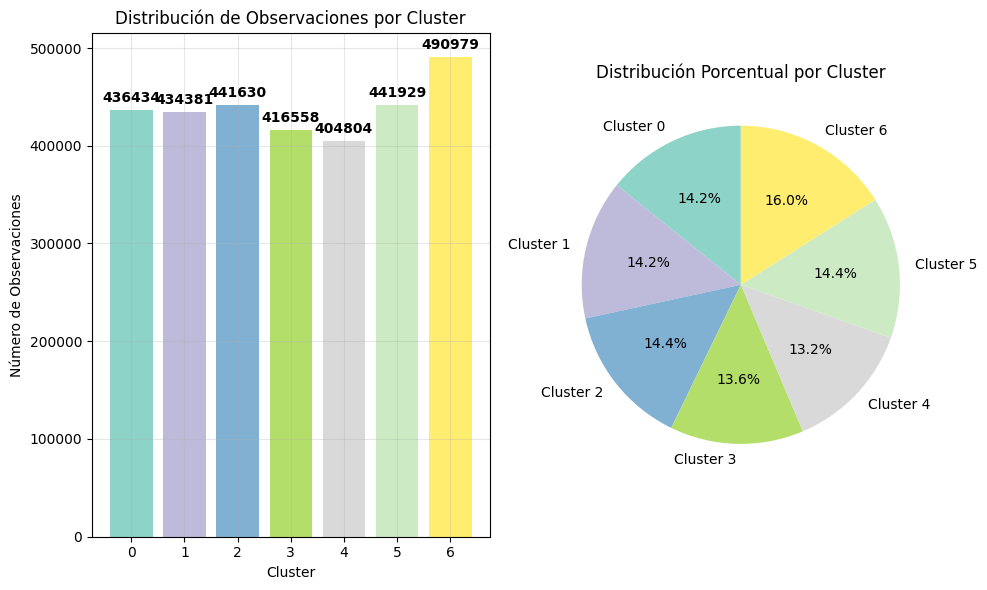

✅ Visualizaciones completadas!


In [98]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b1, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

*Interpretación:*

Como esperábamos, hemos obtenido 7 grupos perfectamente separados, uno para cada día de la semana.

PC1 captura casi el 85% de la varianza, y con PC2 llegan al 96%.

In [99]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [100]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b1_representaciones___silver_transformations_pca_20251110_175523.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [101]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b1_representaciones___silver_logs_20251110_175531.parquet
  Total de registros en log: 1


In [102]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.72 GB / 13.61 GB (51.9%)
[Inicio] Disco usado: 42.71 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 6.72 GB / 13.61 GB (51.9%)
[Final] Disco usado: 42.71 GB / 115.66 GB (36.9%)



In [103]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.73 GB / 13.61 GB (51.9%)
[Inicio limpieza completa de memoria] Disco usado: 42.71 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.58 GB / 13.61 GB (21.4%)
[Final limpieza completa de memoria] Disco usado: 42.71 GB / 115.66 GB (36.9%)



### **Grupo B-2: Representaciones de la hora (inicio del trayecto)**

In [104]:
grupo_b2 = [
    "pickup_hour",
    "pickup_hour_hour_sin",
    "pickup_hour_hour_cos"
]

grupo_nombre = "B2 Representaciones de la hora (inicio)"

In [105]:
# gestión de metadatos
params = {
    "features": grupo_b2,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B2 Representaciones de la hora (inicio)",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "pickup_hour",
      "pickup_hour_hour_sin",
      "pickup_hour_hour_cos"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T17:55:50.074603",
  "model_version": "e5e4457dc949",
  "featureset_version": "B2 Representaciones de la hora (inicio)_e5e4457dc949",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [106]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b2,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b2_representaciones___silver_features_20251110_175604.parquet
  Registros: 3,066,715
  Columnas: 8


In [107]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b2,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - B2 REPRESENTACIONES DE LA HORA (INICIO)
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - B2 Representaciones de la hora (inicio)
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.241
Correlación máxima: 0.234
Correlación mínima: -0.758
Desviación estándar: 0.406

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 2 pares


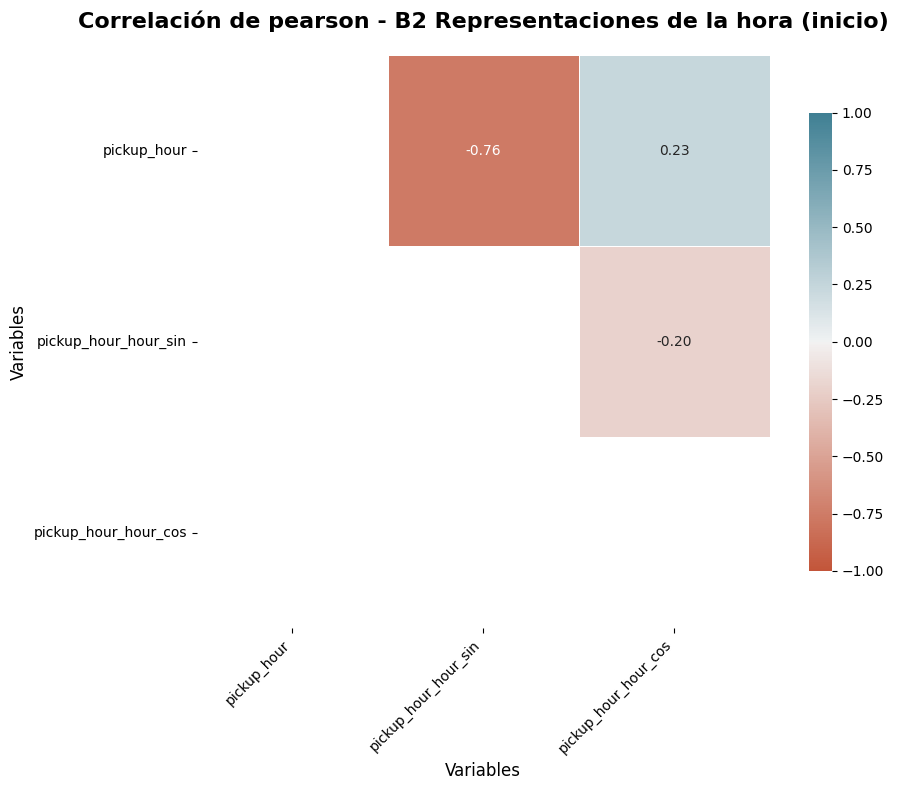


📊 ANÁLISIS DE CORRELACIÓN - B2 REPRESENTACIONES DE LA HORA (INICIO)
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - B2 Representaciones de la hora (inicio)
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.220
Correlación máxima: 0.393
Correlación mínima: -0.777
Desviación estándar: 0.479

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 1 pares


In [108]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b2,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b2,
    group_name = grupo_nombre,
    method = "spearman"
)

Alta correlación lineal y no lineal entre pickup_hour y pickup_hour_hour_sin, y correlación moderada no lineal entre pickup_hour y pickup_hour_hour_cos. Es razonable ya que tanto pickup_hour_hour_sin como pickup_hour_hour_cos son relaciones matemáticas de pickup_hour.

In [109]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [110]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B2 Representaciones de la hora (inicio)",
  "total_rows": 3066715,
  "variables": {
    "pickup_hour": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 23.0,
      "mean": 14.128930794025528,
      "median": 15.0,
      "std": 5.771471504487696,
      "q25": 11.0,
      "q75": 19.0,
      "n_outliers_iqr": 0
    },
    "pickup_hour_hour_sin": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.0,
      "max": 1.0,
      "mean": -0.2915806246379539,
      "median": -0.4999999999999997,
      "std": 0.6430279785926774,
      "q25": -0.8660254037844384,
      "q75": 0.258819045102521,
      "n_outliers_iqr": 283447
    },
    "pickup_hour_hour_cos": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.0,
      "max": 1.0,
      "mean": -0.17903539480947367,
      "median": -0.25881904510252063,
      "std": 0.6851586483415398,
      "q25": -0.8660

- **Análisis de VIF**

In [111]:
analyze_vif(ds_for_correlation_clean, grupo_b2)

               Variable     VIF    Interpretacion
0           pickup_hour  2.3935  Baja correlación
1  pickup_hour_hour_sin  2.3558  Baja correlación
2  pickup_hour_hour_cos  1.0594  Baja correlación

=== Variables con VIF aceptable ===



['pickup_hour', 'pickup_hour_hour_sin', 'pickup_hour_hour_cos']


=== Variables con VIF no aceptable (>= 10) ===



[]

No existe multicolinealidad en estas variables.

- **Clustering**

In [112]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b2, num_clusters_a_probar)

plot_silhouette_scores(scores)

Para k = 2, la silueta media es: 0.7479
Para k = 3, la silueta media es: 0.7141
Para k = 4, la silueta media es: 0.6797
Para k = 5, la silueta media es: 0.7187
Para k = 6, la silueta media es: 0.7020
Para k = 7, la silueta media es: 0.7381
Para k = 8, la silueta media es: 0.6894


In [113]:
k_optimo = 2

In [114]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b2,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['pickup_hour', 'pickup_hour_hour_sin', 'pickup_hour_hour_cos']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 35272603.7063

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1096470|
|1      |1970245|
+-------+-------+


⏱️ Tiempo de ejecución: 57.88 segundos
📊 Balance de clusters - Min: 1096470,  Max: 1970245, Std: 436887.50


In [115]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.747908376503138,
  "wssse": 35272603.706260525,
  "cluster_sizes": [
    [
      1,
      1970245
    ],
    [
      0,
      1096470
    ]
  ],
  "silhouette_all_k": {
    "2": 0.747908376503138,
    "3": 0.7140582595582442,
    "4": 0.679746285002854,
    "5": 0.718726861055944,
    "6": 0.7020140435765548,
    "7": 0.7380709334951466,
    "8": 0.6894241464731323
  },
  "centers": [
    [
      7.792697474623109,
      0.47622367384591613,
      -0.36909356000846855
    ],
    [
      17.655136797707897,
      -0.7188748845708238,
      -0.07326526145213236
    ]
  ]
}


In [116]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b2_representaciones___silver_clusters_20251110_181023.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [117]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b2, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [118]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


2. Perfiles de clusters...


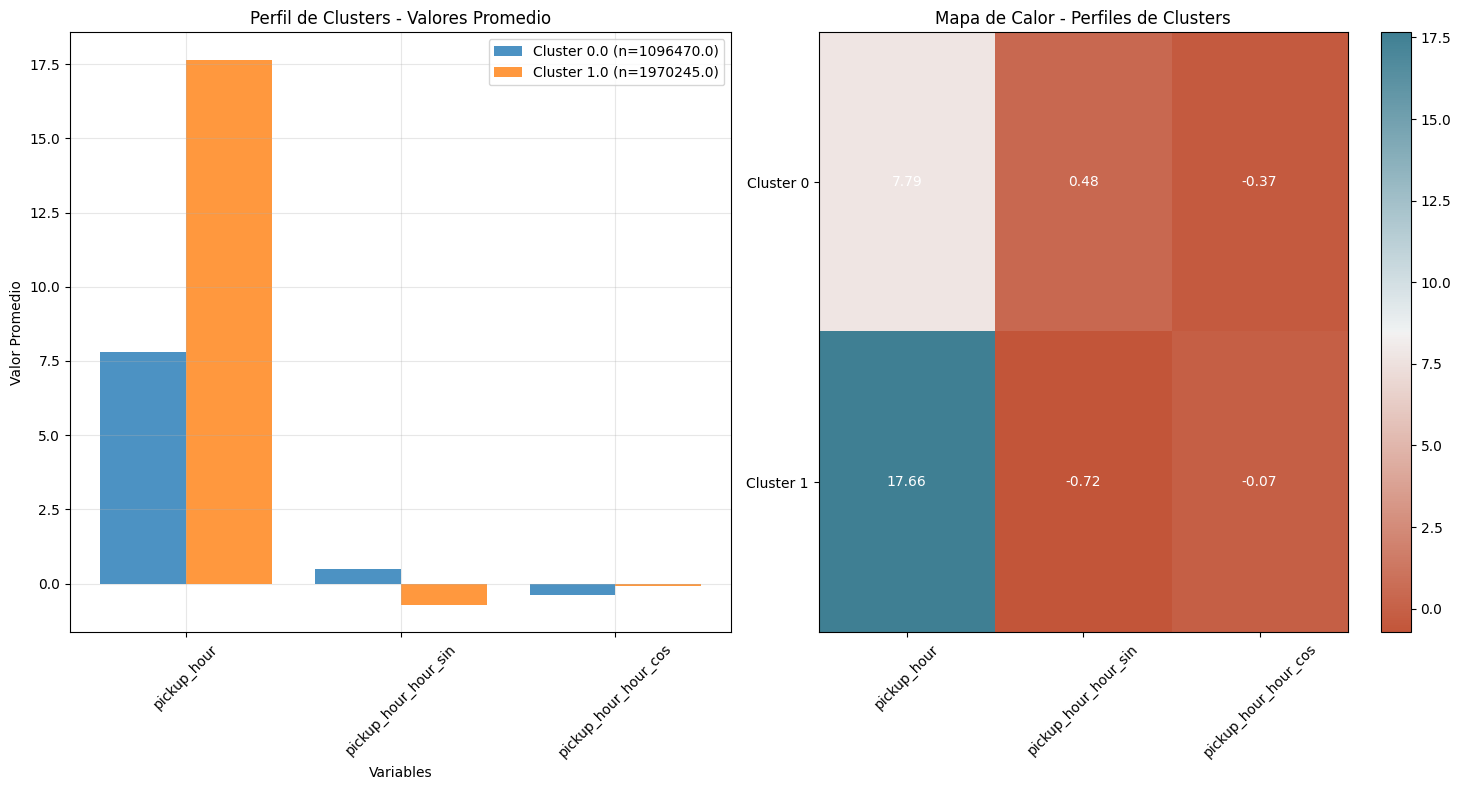

3. Distribución de clusters...


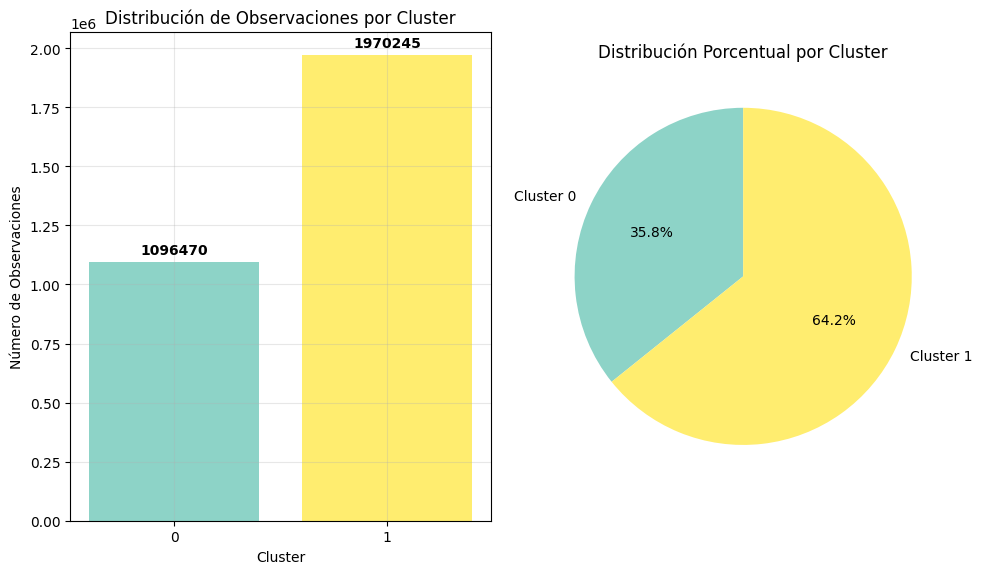

✅ Visualizaciones completadas!


In [119]:
# crea todas las visualizaciones
visualize_clusters_complete(
  ds_con_clusters,
  grupo_b2, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Podemos observar que los 2 grupos obtenidos, perfectamente separados, están a su vez compuestos por 24 subgrupos también perfectamente separados; serían las 24 horas del día, es decir las 24 categorías de pickup_hour.

PC1 obtiene algo más del 98% de la varianza.

In [120]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [121]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b2_representaciones___silver_transformations_pca_20251110_181239.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [122]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b2_representaciones___silver_logs_20251110_181241.parquet
  Total de registros en log: 1


In [123]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.72 GB / 13.61 GB (51.8%)
[Inicio] Disco usado: 42.73 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 6.72 GB / 13.61 GB (51.8%)
[Final] Disco usado: 42.73 GB / 115.66 GB (36.9%)



In [124]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.72 GB / 13.61 GB (51.8%)
[Inicio limpieza completa de memoria] Disco usado: 42.73 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.59 GB / 13.61 GB (21.5%)
[Final limpieza completa de memoria] Disco usado: 42.73 GB / 115.66 GB (36.9%)



### **Grupo B-3: Representaciones del día de la semana (final trayecto)**

In [125]:
grupo_b3 = [
    "tpep_dropoff_datetime_dayofweek",
    "tpep_dropoff_datetime_dayofweek_sin",
    "tpep_dropoff_datetime_dayofweek_cos"
]

grupo_nombre = "B3 Representaciones del día de la semana (final)"

In [126]:
# gestión de metadatos
params = {
    "features": grupo_b3,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B3 Representaciones del d\u00eda de la semana (final)",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_dropoff_datetime_dayofweek",
      "tpep_dropoff_datetime_dayofweek_sin",
      "tpep_dropoff_datetime_dayofweek_cos"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T18:12:51.219498",
  "model_version": "6a8cd3cdb313",
  "featureset_version": "B3 Representaciones del d\u00eda de la semana (final)_6a8cd3cdb313",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [127]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b3,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b3_representaciones___silver_features_20251110_181252.parquet
  Registros: 3,066,715
  Columnas: 8


In [128]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b3,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - B3 REPRESENTACIONES DEL DÍA DE LA SEMANA (FINAL)
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - B3 Representaciones del día de la semana (final)
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.363
Correlación máxima: -0.013
Correlación mínima: -0.730
Desviación estándar: 0.293

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 1 pares


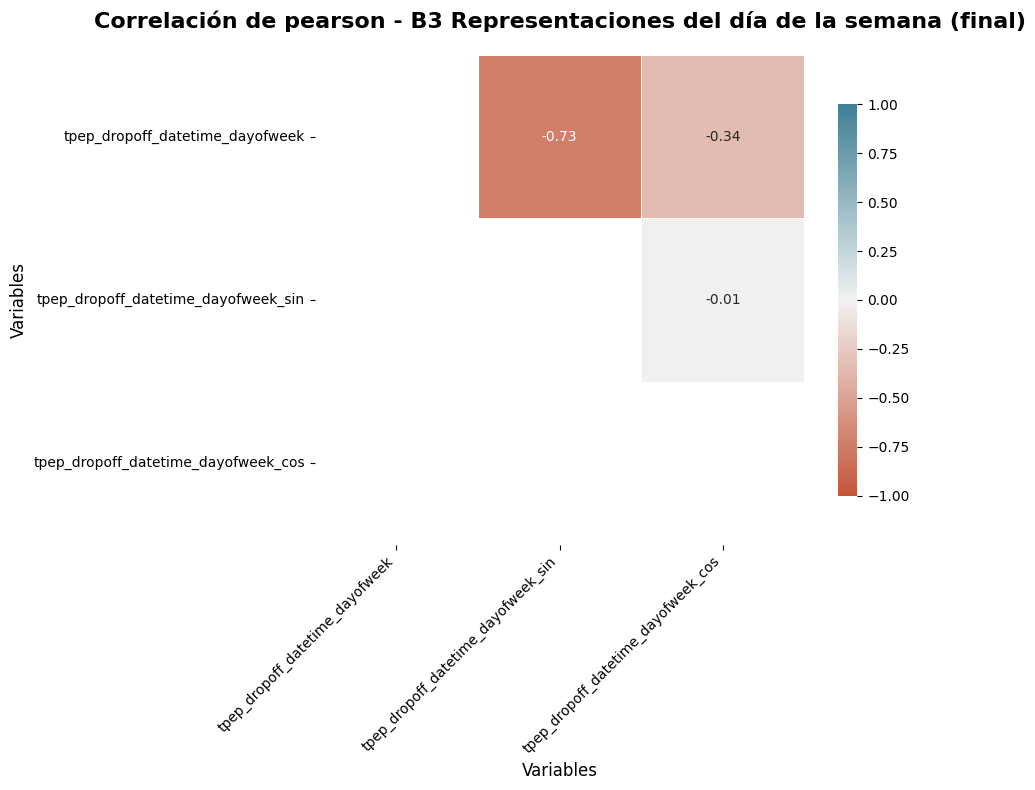


📊 ANÁLISIS DE CORRELACIÓN - B3 REPRESENTACIONES DEL DÍA DE LA SEMANA (FINAL)
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - B3 Representaciones del día de la semana (final)
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.345
Correlación máxima: 0.205
Correlación mínima: -0.712
Desviación estándar: 0.396

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 1 pares


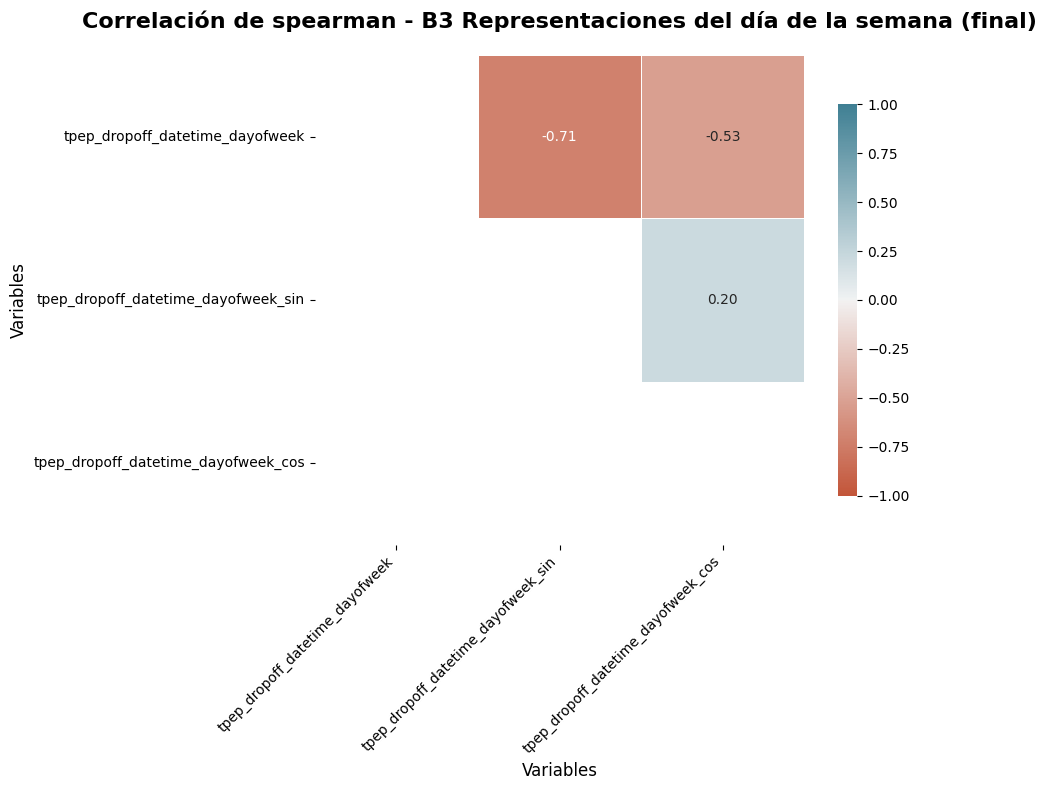

In [129]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b3,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b3,
    group_name = grupo_nombre,
    method = "spearman"
)

De forma análoga a las variables de pickup, tenemos relaciones lineales y no lineales entre estas tres variables, dos de ellas obtenidas matemáticamente a partir de la tercera.

In [130]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [131]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B3 Representaciones del d\u00eda de la semana (final)",
  "total_rows": 3066715,
  "variables": {
    "tpep_dropoff_datetime_dayofweek": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 7.0,
      "mean": 4.003352447162517,
      "median": 4.0,
      "std": 1.9952276841827707,
      "q25": 2.0,
      "q75": 6.0,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_dayofweek_sin": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9749279121818236,
      "max": 0.9749279121818236,
      "mean": 0.005957809865124864,
      "median": 0.0,
      "std": 0.712351321763574,
      "q25": -0.7818314824680299,
      "q75": 0.7818314824680298,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_dayofweek_cos": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9009688679024191,
      "max": 1.0,
      "mean": -0.003537338394104427,
     

- **Análisis de VIF**

In [132]:
analyze_vif(ds_for_correlation_clean, grupo_b3)

                              Variable     VIF    Interpretacion
0      tpep_dropoff_datetime_dayofweek  2.9265  Baja correlación
1  tpep_dropoff_datetime_dayofweek_sin  2.5800  Baja correlación
2  tpep_dropoff_datetime_dayofweek_cos  1.3672  Baja correlación

=== Variables con VIF aceptable ===



['tpep_dropoff_datetime_dayofweek',
 'tpep_dropoff_datetime_dayofweek_sin',
 'tpep_dropoff_datetime_dayofweek_cos']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin multicolinealidad.

- **Clustering**

Para k = 2, la silueta media es: 0.7536
Para k = 3, la silueta media es: 0.7274
Para k = 4, la silueta media es: 0.6459
Para k = 5, la silueta media es: 0.6124
Para k = 6, la silueta media es: 0.8531
Para k = 7, la silueta media es: 1.0000
Para k = 8, la silueta media es: 1.0000


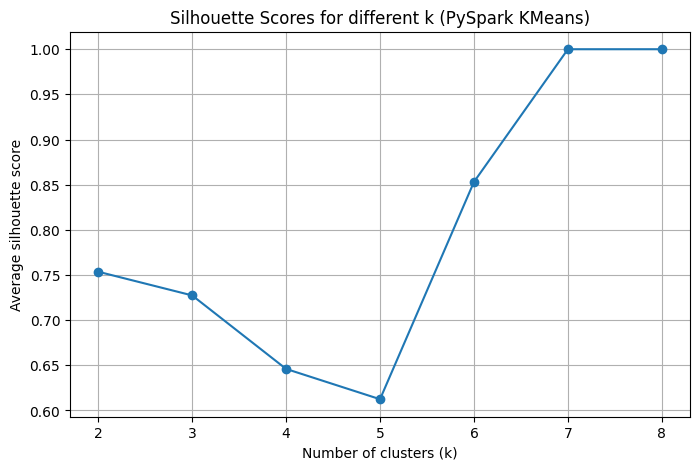

In [133]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b3, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [134]:
k_optimo = 7

In [135]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b3,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 7
- Variables utilizadas: ['tpep_dropoff_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_cos']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 0.0000

Distribución de clusters:
+-------+------+
|cluster|count |
+-------+------+
|0      |439263|
|1      |432255|
|2      |441377|
|3      |416681|
|4      |405500|
|5      |441034|
|6      |490605|
+-------+------+


⏱️ Tiempo de ejecución: 55.83 segundos
📊 Balance de clusters - Min: 405500,  Max: 490605, Std: 24880.21


In [136]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 7,
  "silhouette_score": 0.9999999999999999,
  "wssse": 0.0,
  "cluster_sizes": [
    [
      1,
      432255
    ],
    [
      6,
      490605
    ],
    [
      3,
      416681
    ],
    [
      5,
      441034
    ],
    [
      4,
      405500
    ],
    [
      2,
      441377
    ],
    [
      0,
      439263
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7535934216798245,
    "3": 0.7273631958014055,
    "4": 0.6459460368428449,
    "5": 0.6123972647275214,
    "6": 0.8530571309338695,
    "7": 0.9999999999999999,
    "8": 0.9999999999999999
  },
  "centers": [
    [
      1.0,
      0.0,
      1.0
    ],
    [
      6.0,
      -0.9749279121763069,
      -0.22252093395595898
    ],
    [
      7.000000000000001,
      -0.7818314824668933,
      0.6234898018578496
    ],
    [
      4.0,
      0.43388373911398503,
      -0.9009688678972739
    ],
    [
      2.0,
      0.7818314824654204,
      0.6234898018592279
    ],
    [
      5.0,
      -0.43388373911384

In [137]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b3_representaciones___silver_clusters_20251110_182715.parquet
  Registros: 3,066,715
  Clusters únicos: 7


- **Reducción de dimensionalidad**

In [138]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b3, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [139]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


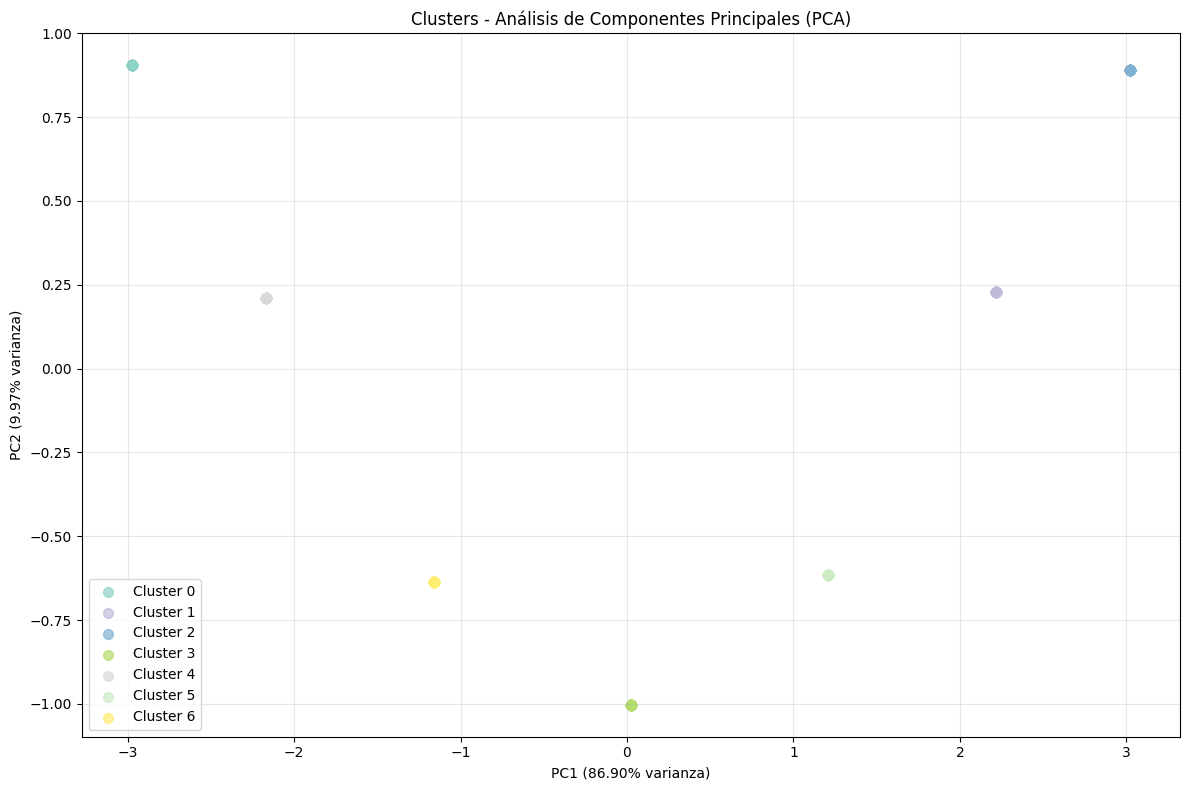

2. Perfiles de clusters...


3. Distribución de clusters...


✅ Visualizaciones completadas!


In [140]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b3, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Obtenidos 7 grupos perfectamente separados, correspondientes a los 7 días de la semana. La PC1 obtiene algo menos del 90% de la varianza.

In [141]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [142]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b3_representaciones___silver_transformations_pca_20251110_182756.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [143]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b3_representaciones___silver_logs_20251110_182801.parquet
  Total de registros en log: 1


In [144]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.78 GB / 13.61 GB (52.3%)
[Inicio] Disco usado: 42.75 GB / 115.66 GB (37.0%)


[Final] Memoria usada: 6.78 GB / 13.61 GB (52.3%)
[Final] Disco usado: 42.75 GB / 115.66 GB (37.0%)



In [145]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.78 GB / 13.61 GB (52.3%)
[Inicio limpieza completa de memoria] Disco usado: 42.75 GB / 115.66 GB (37.0%)


[Final limpieza completa de memoria] Memoria usada: 2.65 GB / 13.61 GB (21.9%)
[Final limpieza completa de memoria] Disco usado: 42.75 GB / 115.66 GB (37.0%)



## **Grupo B: Redundancia temporal**

### **Grupo B-4: Correlación cruzada (inicio vs final)**

**B-4-1. Día de la semana**

In [146]:
grupo_b41 = [
    "tpep_pickup_datetime_dayofweek",
    "tpep_dropoff_datetime_dayofweek"
]

grupo_nombre = "B41 Correlación cruzada (inicio vs final): dayofweek"

In [147]:
# gestión de metadatos
params = {
    "features": grupo_b41,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B41 Correlaci\u00f3n cruzada (inicio vs final): dayofweek",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_dayofweek",
      "tpep_dropoff_datetime_dayofweek"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T18:28:08.528934",
  "model_version": "b63a9a403576",
  "featureset_version": "B41 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_b63a9a403576",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [148]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b41,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b41_correlación_cruz__silver_features_20251110_182816.parquet
  Registros: 3,066,715
  Columnas: 7


In [149]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b41,
    group_name=grupo_nombre
)

- **Matriz de correlación**

In [150]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b41,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b41,
    group_name = grupo_nombre,
    method = "spearman"
)


📊 ANÁLISIS DE CORRELACIÓN - B41 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - B41 Correlación cruzada (inicio vs final): dayofweek
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.990
Correlación máxima: 0.990
Correlación mínima: 0.990
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares



📊 ANÁLISIS DE CORRELACIÓN - B41 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - B41 Correlación cruzada (inicio vs final): dayofweek
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.990
Correlación máxima: 0.990
Correlación mínima: 0.990
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


Muy alta correlación lineal y no lineal (0,99 en ambos casos) entre el día de la semana de inicio del viaje y del final del viaje, como es lógico. Las únicas excepciones, viajes que se inician antes de las 0 h y finalizan por tanto al día siguiente.

In [151]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [152]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B41 Correlaci\u00f3n cruzada (inicio vs final): dayofweek",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_dayofweek": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 7.0,
      "mean": 4.008377694047214,
      "median": 4.0,
      "std": 1.9938890811936483,
      "q25": 2.0,
      "q75": 6.0,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_dayofweek": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 7.0,
      "mean": 4.003352447162517,
      "median": 4.0,
      "std": 1.9952276841827707,
      "q25": 2.0,
      "q75": 6.0,
      "n_outliers_iqr": 0
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.9904100679668643,
        "max_correlation": 0.9904100679668643,
        "min_correlation": 0.9904100679668643,
        "std_correla

- **Análisis de VIF**

In [153]:
analyze_vif(ds_for_correlation_clean, grupo_b41)

                          Variable      VIF          Interpretacion
0   tpep_pickup_datetime_dayofweek  52.3892  Alta multicolinealidad
1  tpep_dropoff_datetime_dayofweek  52.3892  Alta multicolinealidad

=== Variables con VIF aceptable ===



[]


=== Variables con VIF no aceptable (>= 10) ===



['tpep_pickup_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek']

En el caso de tener sólo dos variables, realmente no medimos con VIF la multicolinealidad sino la correlación lineal entre ambas variables, que como hemos visto es muy elevada; por tanto, VIF resulta en un valor muy elevado.

- **Clustering**

Para k = 2, la silueta media es: 0.7827
Para k = 3, la silueta media es: 0.7323
Para k = 4, la silueta media es: 0.7933
Para k = 5, la silueta media es: 0.8395
Para k = 6, la silueta media es: 0.8267
Para k = 7, la silueta media es: 0.9717
Para k = 8, la silueta media es: 0.9902


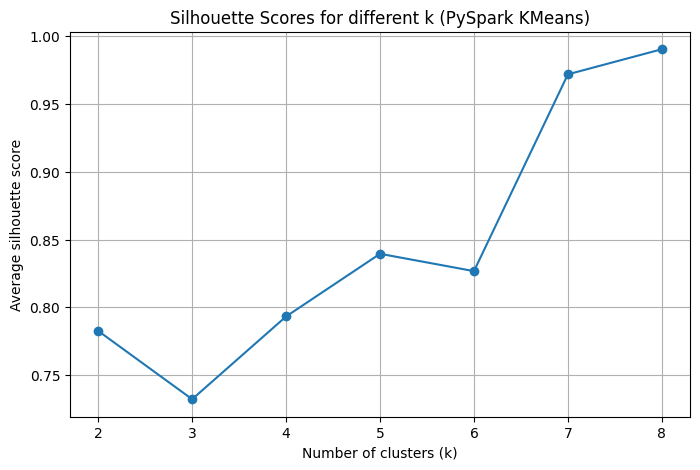

In [154]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b41, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [155]:
k_optimo = 8

In [156]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b41,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 8
- Variables utilizadas: ['tpep_pickup_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 20064.2531

Distribución de clusters:
+-------+------+
|cluster|count |
+-------+------+
|0      |436431|
|1      |437936|
|2      |435692|
|3      |419345|
|4      |404806|
|5      |438374|
|6      |488190|
|7      |5941  |
+-------+------+


⏱️ Tiempo de ejecución: 56.43 segundos
📊 Balance de clusters - Min: 5941,  Max: 488190, Std: 144373.44


In [158]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 8,
  "silhouette_score": 0.9902000216189057,
  "wssse": 20064.253067766516,
  "cluster_sizes": [
    [
      1,
      437936
    ],
    [
      6,
      488190
    ],
    [
      3,
      419345
    ],
    [
      5,
      438374
    ],
    [
      4,
      404806
    ],
    [
      7,
      5941
    ],
    [
      2,
      435692
    ],
    [
      0,
      436431
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7826613591700509,
    "3": 0.7323398929179331,
    "4": 0.7932922370404436,
    "5": 0.8394828200505744,
    "6": 0.8267133271243289,
    "7": 0.9716985284674096,
    "8": 0.9902000216189057
  },
  "centers": [
    [
      1.0,
      1.007119109320832
    ],
    [
      5.9918755251908955,
      6.012981348872895
    ],
    [
      7.0,
      7.0
    ],
    [
      3.9933443823105077,
      4.006355149101575
    ],
    [
      1.9999925890426524,
      2.0059658206647133
    ],
    [
      4.9999931565284434,
      5.0000068434715566
    ],
    [
      3.0,
    

In [159]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b41_correlación_cruz__silver_clusters_20251110_184024.parquet
  Registros: 3,066,715
  Clusters únicos: 8


- **Reducción de dimensionalidad**

In [160]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b41, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [161]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


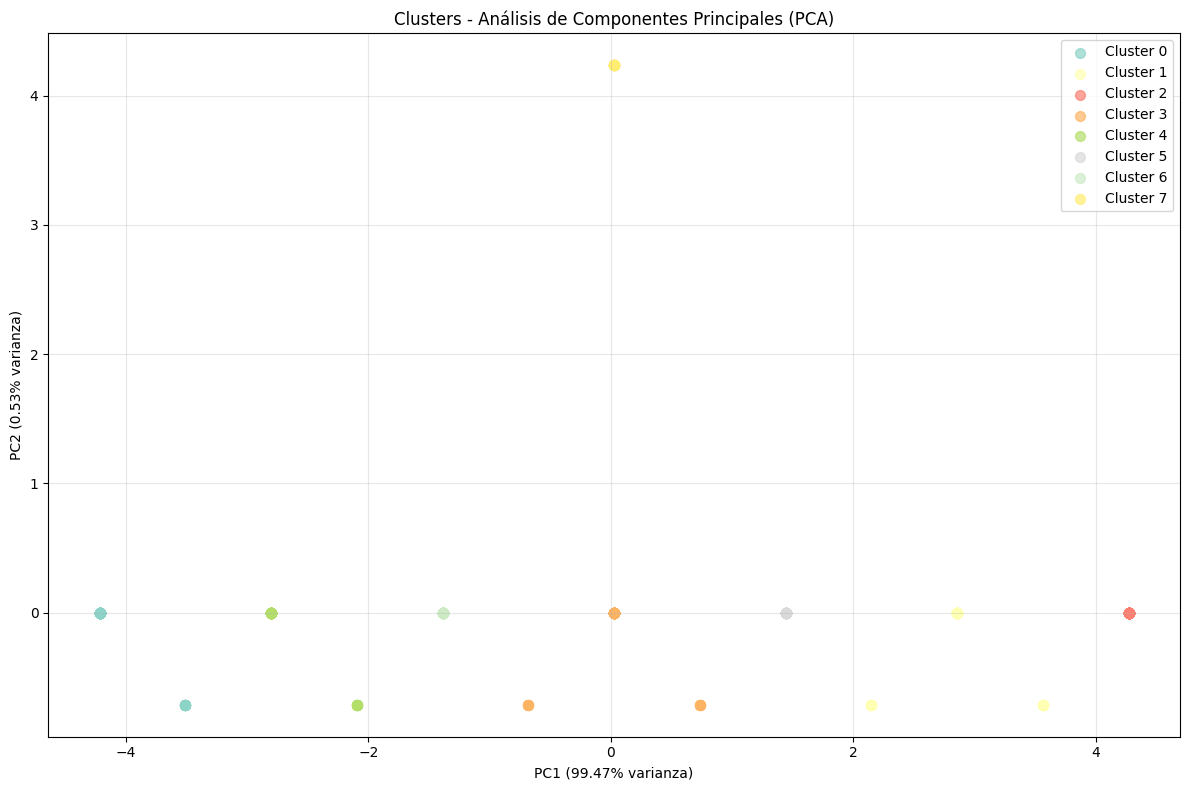

2. Perfiles de clusters...


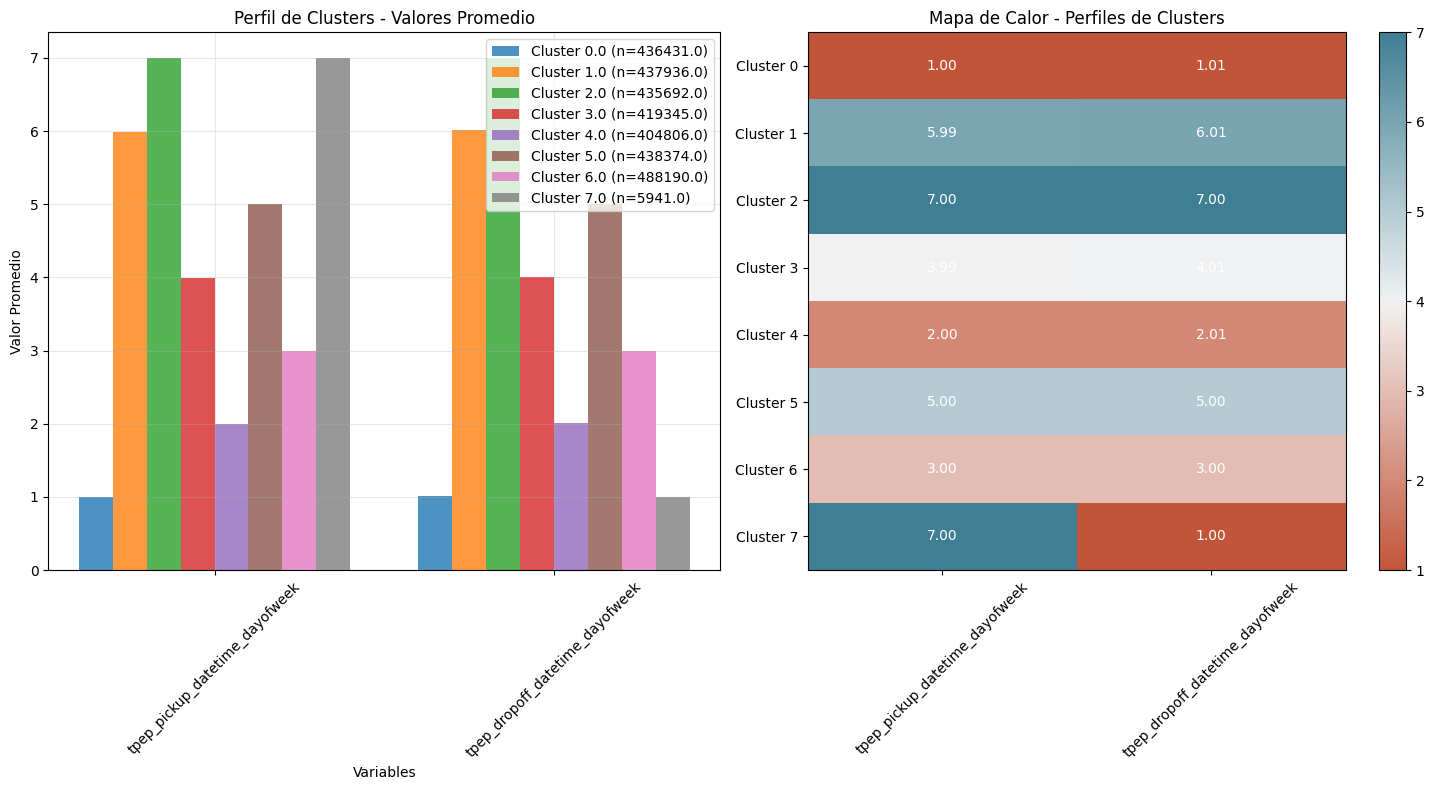

3. Distribución de clusters...


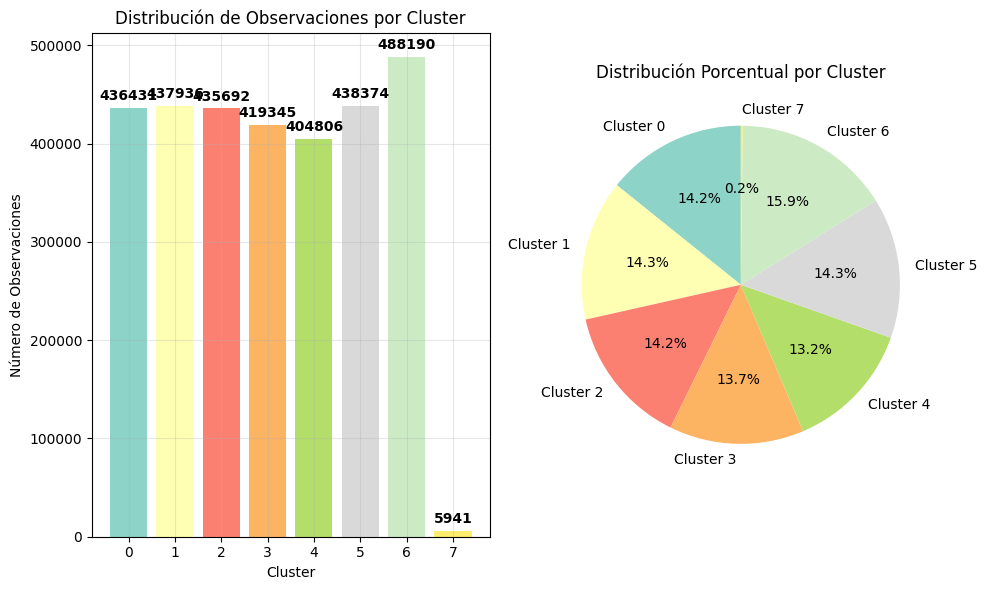

✅ Visualizaciones completadas!


In [162]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b41, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

7 grupos para variables que indican el día de la semana.

La PC1 obtiene más del 99% de la varianza.

In [163]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [164]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b41_correlación_cruz__silver_transformations_pca_20251110_184107.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [165]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b41_correlación_cruz__silver_logs_20251110_184108.parquet
  Total de registros en log: 1


In [166]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.80 GB / 13.61 GB (52.5%)
[Inicio] Disco usado: 42.77 GB / 115.66 GB (37.0%)


[Final] Memoria usada: 6.80 GB / 13.61 GB (52.5%)
[Final] Disco usado: 42.77 GB / 115.66 GB (37.0%)



In [167]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.80 GB / 13.61 GB (52.5%)
[Inicio limpieza completa de memoria] Disco usado: 42.77 GB / 115.66 GB (37.0%)


[Final limpieza completa de memoria] Memoria usada: 2.67 GB / 13.61 GB (22.1%)
[Final limpieza completa de memoria] Disco usado: 42.77 GB / 115.66 GB (37.0%)



**B-4-2. Día de la semana (sin)**

In [168]:
grupo_b42 = [
    "tpep_pickup_datetime_dayofweek_sin",
    "tpep_dropoff_datetime_dayofweek_sin"
]

grupo_nombre = "B42 Correlación cruzada (inicio vs final): dayofweek_sin"

In [169]:
# gestión de metadatos
params = {
    "features": grupo_b42,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B42 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_sin",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_dayofweek_sin",
      "tpep_dropoff_datetime_dayofweek_sin"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T18:41:13.624919",
  "model_version": "1cc139978591",
  "featureset_version": "B42 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_sin_1cc139978591",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [170]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b42,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b42_correlación_cruz__silver_features_20251110_184117.parquet
  Registros: 3,066,715
  Columnas: 7


In [171]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b42,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - B42 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK_SIN
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - B42 Correlación cruzada (inicio vs final): dayofweek_sin
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.997
Correlación máxima: 0.997
Correlación mínima: 0.997
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares



📊 ANÁLISIS DE CORRELACIÓN - B42 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK_SIN
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - B42 Correlación cruzada (inicio vs final): dayofweek_sin
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.997
Correlación máxima: 0.997
Correlación mínima: 0.997
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


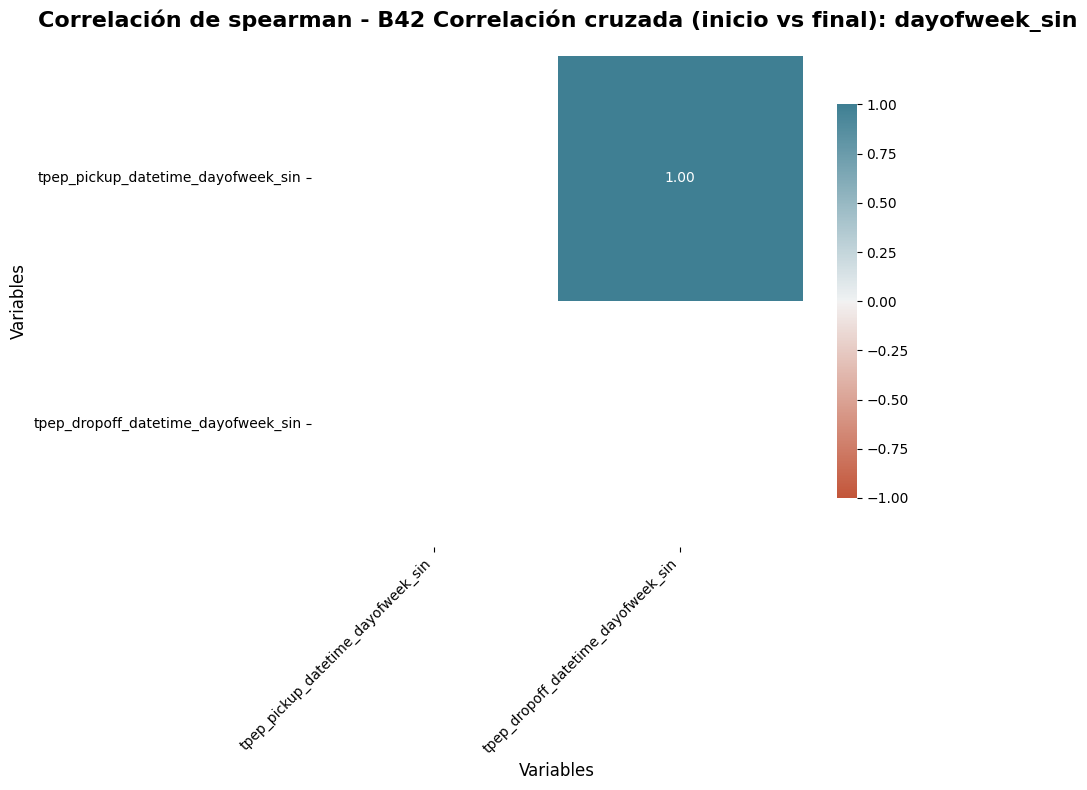

In [172]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b42,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b42,
    group_name = grupo_nombre,
    method = "spearman"
)

Al aplicar la función seno al día de la semana tenemos total correlación entre las dos variables.

In [173]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [174]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B42 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_sin",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_dayofweek_sin": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9749279121818236,
      "max": 0.9749279121818236,
      "mean": 0.0050148707835838665,
      "median": 0.0,
      "std": 0.7128735392183918,
      "q25": -0.7818314824680299,
      "q75": 0.7818314824680298,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_dayofweek_sin": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9749279121818236,
      "max": 0.9749279121818236,
      "mean": 0.005957809865124864,
      "median": 0.0,
      "std": 0.712351321763574,
      "q25": -0.7818314824680299,
      "q75": 0.7818314824680298,
      "n_outliers_iqr": 0
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correl

- **Análisis de VIF**

In [175]:
analyze_vif(ds_for_correlation_clean, grupo_b42)

                              Variable       VIF          Interpretacion
0   tpep_pickup_datetime_dayofweek_sin  160.6363  Alta multicolinealidad
1  tpep_dropoff_datetime_dayofweek_sin  160.6363  Alta multicolinealidad

=== Variables con VIF aceptable ===



[]


=== Variables con VIF no aceptable (>= 10) ===



['tpep_pickup_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_sin']

Como en el caso del día de la semana, al aplicar el seno tenemos una mayor correlación lineal.

- **Clustering**

In [176]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b42, num_clusters_a_probar)

plot_silhouette_scores(scores)

Para k = 2, la silueta media es: 0.8261
Para k = 3, la silueta media es: 0.7294
Para k = 4, la silueta media es: 0.8150
Para k = 5, la silueta media es: 0.7751
Para k = 6, la silueta media es: 0.9561
Para k = 7, la silueta media es: 0.9843
Para k = 8, la silueta media es: 0.9861


In [177]:
k_optimo = 7

In [178]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b42,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 7
- Variables utilizadas: ['tpep_pickup_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_sin']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 20629.1396

Distribución de clusters:
+-------+------+
|cluster|count |
+-------+------+
|0      |439250|
|1      |895781|
|2      |417003|
|3      |434378|
|4      |2667  |
|5      |433326|
|6      |444310|
+-------+------+


⏱️ Tiempo de ejecución: 57.83 segundos
📊 Balance de clusters - Min: 2667,  Max: 895781, Std: 238924.80


In [179]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 7,
  "silhouette_score": 0.9842815928330543,
  "wssse": 20629.139570437233,
  "cluster_sizes": [
    [
      1,
      895781
    ],
    [
      6,
      444310
    ],
    [
      3,
      434378
    ],
    [
      5,
      433326
    ],
    [
      4,
      2667
    ],
    [
      2,
      417003
    ],
    [
      0,
      439250
    ]
  ],
  "silhouette_all_k": {
    "2": 0.8261390888579111,
    "3": 0.7293958724575845,
    "4": 0.8150098018149798,
    "5": 0.7750770467110742,
    "6": 0.9560773055693115,
    "7": 0.9842815928330543,
    "8": 0.9860658100235126
  },
  "centers": [
    [
      -0.7790130463350667,
      -0.7833951569130653
    ],
    [
      0.8876677291336922,
      0.8865037364099807
    ],
    [
      0.4306478429006784,
      0.43648011556955146
    ],
    [
      -0.9749279121763016,
      -0.9724011725476168
    ],
    [
      0.4342170694199108,
      -0.434695203944036
    ],
    [
      -4.054128749832351e-06,
      3.6085140631673607e-06
  

In [180]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b42_correlación_cruz__silver_clusters_20251110_185316.parquet
  Registros: 3,066,715
  Clusters únicos: 7


- **Reducción de dimensionalidad**

In [181]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b42, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [182]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


2. Perfiles de clusters...


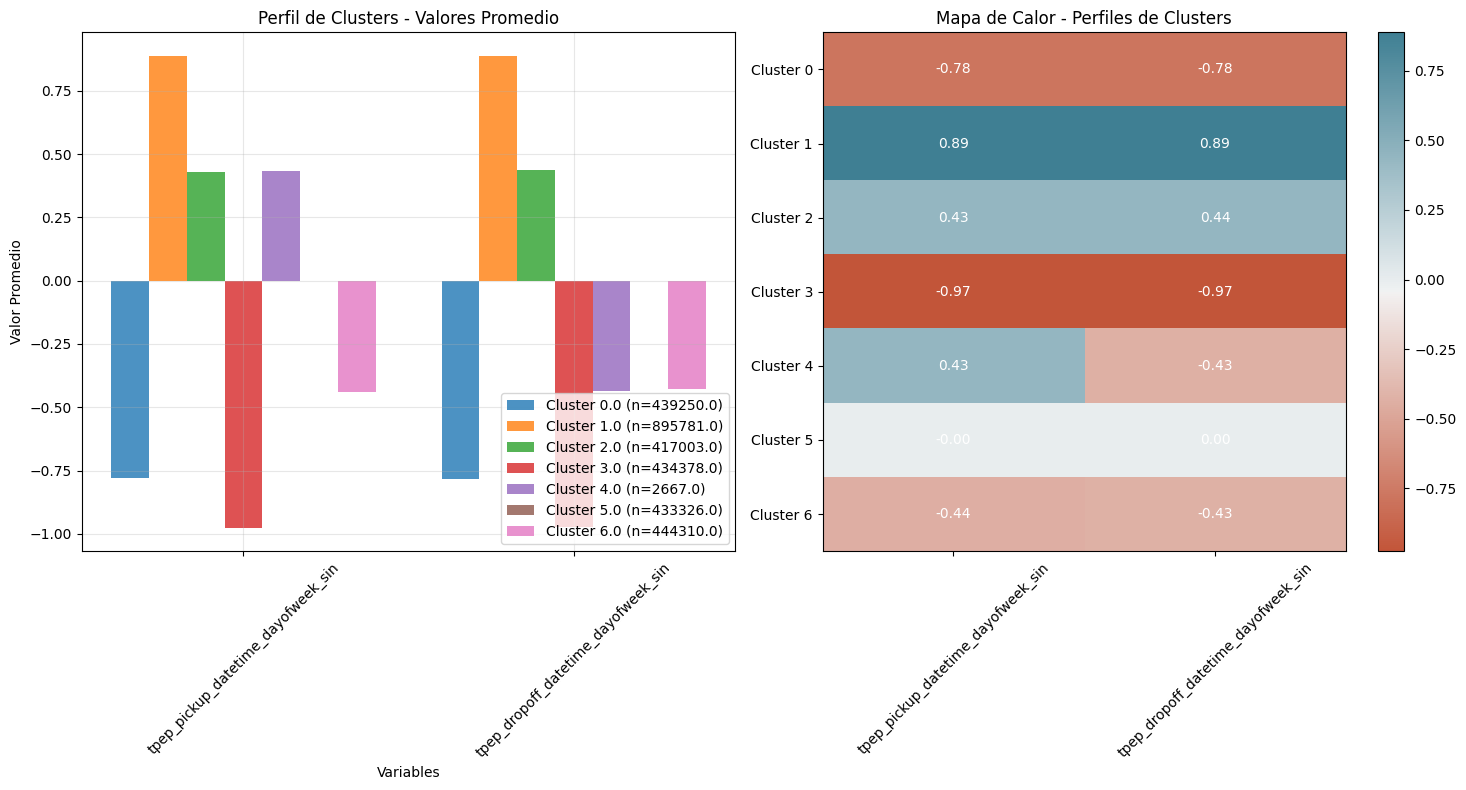

3. Distribución de clusters...


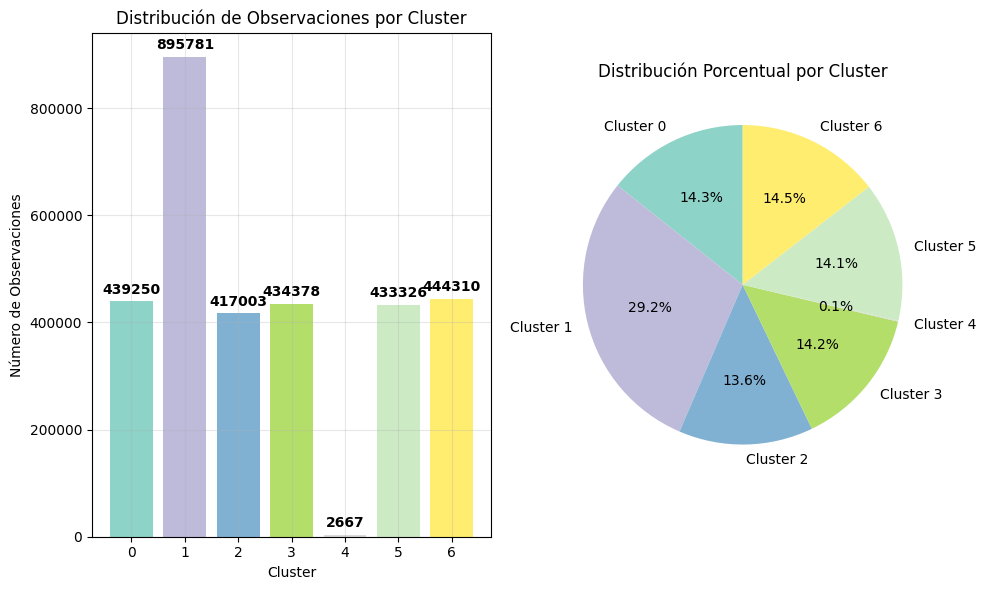

✅ Visualizaciones completadas!


In [183]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b42, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

7 grupos perfectamente separados, uno por cada día de la semana.

PC1 obtiene un mayor porcentaje de la varianza, llegando al 99,8%.

In [184]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [185]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b42_correlación_cruz__silver_transformations_pca_20251110_185347.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [186]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b42_correlación_cruz__silver_logs_20251110_185348.parquet
  Total de registros en log: 1


In [187]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.77 GB / 13.61 GB (52.3%)
[Inicio] Disco usado: 42.80 GB / 115.66 GB (37.0%)


[Final] Memoria usada: 6.77 GB / 13.61 GB (52.3%)
[Final] Disco usado: 42.80 GB / 115.66 GB (37.0%)



In [188]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.77 GB / 13.61 GB (52.3%)
[Inicio limpieza completa de memoria] Disco usado: 42.80 GB / 115.66 GB (37.0%)


[Final limpieza completa de memoria] Memoria usada: 2.66 GB / 13.61 GB (22.0%)
[Final limpieza completa de memoria] Disco usado: 42.80 GB / 115.66 GB (37.0%)



**B-4-3. Día de la semana (cos)**

In [189]:
grupo_b43 = [
    "tpep_pickup_datetime_dayofweek_cos",
    "tpep_dropoff_datetime_dayofweek_cos"
]

grupo_nombre = "B43 Correlación cruzada (inicio vs final): dayofweek_cos"

In [190]:
# gestión de metadatos
params = {
    "features": grupo_b43,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B43 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_cos",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_dayofweek_cos",
      "tpep_dropoff_datetime_dayofweek_cos"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T18:54:05.858607",
  "model_version": "e5537d555026",
  "featureset_version": "B43 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_cos_e5537d555026",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [191]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b43,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b43_correlación_cruz__silver_features_20251110_185406.parquet
  Registros: 3,066,715
  Columnas: 7


In [192]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b43,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - B43 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK_COS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - B43 Correlación cruzada (inicio vs final): dayofweek_cos
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.997
Correlación máxima: 0.997
Correlación mínima: 0.997
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares



📊 ANÁLISIS DE CORRELACIÓN - B43 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAYOFWEEK_COS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - B43 Correlación cruzada (inicio vs final): dayofweek_cos
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.996
Correlación máxima: 0.996
Correlación mínima: 0.996
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


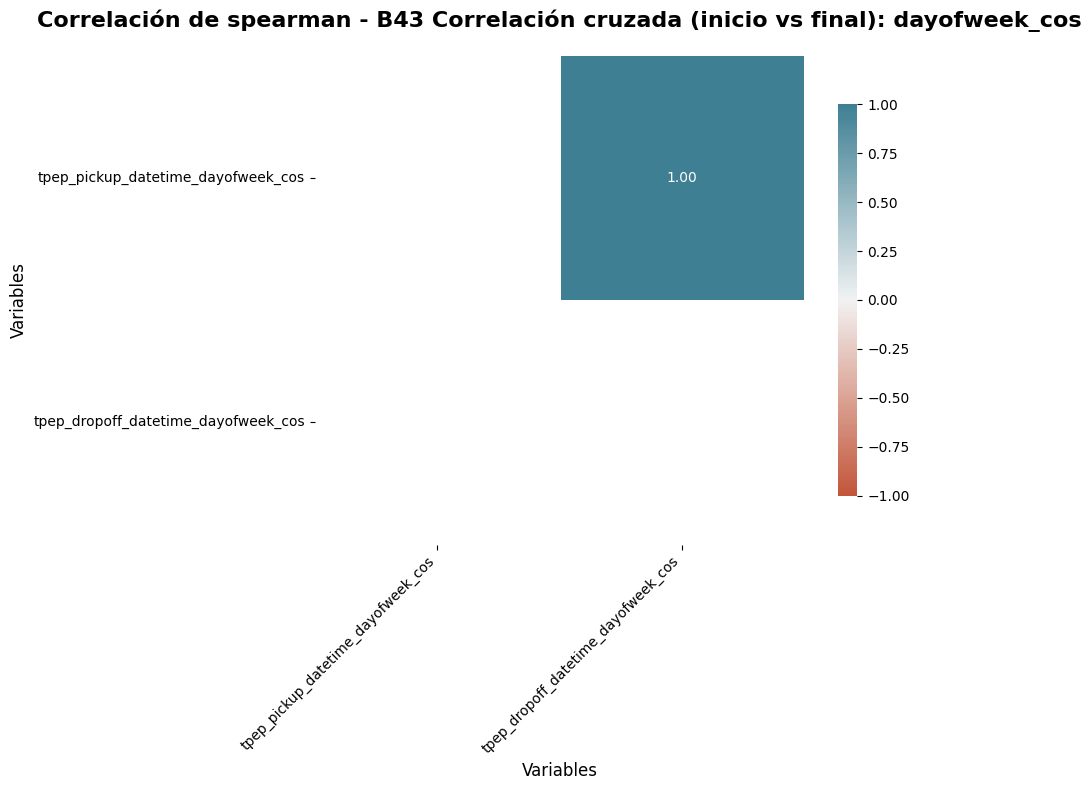

In [193]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b43,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b43,
    group_name = grupo_nombre,
    method = "spearman"
)

Aplicando el coseno al día de la semana obtenemos el mismo resultado que con el seno: correlación máxima lineal y no lineal.

In [194]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [195]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B43 Correlaci\u00f3n cruzada (inicio vs final): dayofweek_cos",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_dayofweek_cos": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9009688679024191,
      "max": 1.0,
      "mean": -0.004958095224509289,
      "median": -0.22252093395631434,
      "std": 0.7012573789349609,
      "q25": -0.900968867902419,
      "q75": 0.6234898018587336,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_dayofweek_cos": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.9009688679024191,
      "max": 1.0,
      "mean": -0.003537338394104427,
      "median": -0.22252093395631434,
      "std": 0.7017890795578555,
      "q25": -0.900968867902419,
      "q75": 0.6234898018587336,
      "n_outliers_iqr": 0
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_co

- **Análisis de VIF**

In [196]:
analyze_vif(ds_for_correlation_clean, grupo_b43)

                              Variable       VIF          Interpretacion
0   tpep_pickup_datetime_dayofweek_cos  151.1254  Alta multicolinealidad
1  tpep_dropoff_datetime_dayofweek_cos  151.1254  Alta multicolinealidad

=== Variables con VIF aceptable ===



[]


=== Variables con VIF no aceptable (>= 10) ===



['tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_dayofweek_cos']

Análogamente al seno, con el coseno tenemos una muy alta correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.8913
Para k = 3, la silueta media es: 0.9655
Para k = 4, la silueta media es: 0.9879
Para k = 5, la silueta media es: 0.9903
Para k = 6, la silueta media es: 0.9918
Para k = 7, la silueta media es: 0.9936
Para k = 8, la silueta media es: 0.9942


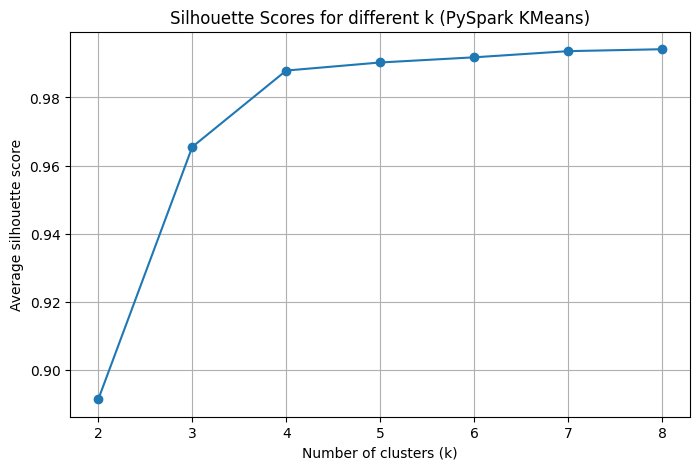

In [197]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b43, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [198]:
k_optimo = 4

In [199]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b43,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 4
- Variables utilizadas: ['tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_dayofweek_cos']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 9956.4512

Distribución de clusters:
+-------+------+
|cluster|count |
+-------+------+
|0      |844026|
|1      |861275|
|2      |924983|
|3      |436431|
+-------+------+


⏱️ Tiempo de ejecución: 56.78 segundos
📊 Balance de clusters - Min: 436431,  Max: 924983, Std: 193038.12


In [200]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 4,
  "silhouette_score": 0.9878944946990537,
  "wssse": 9956.451212129294,
  "cluster_sizes": [
    [
      1,
      861275
    ],
    [
      3,
      436431
    ],
    [
      2,
      924983
    ],
    [
      0,
      844026
    ]
  ],
  "silhouette_all_k": {
    "2": 0.891339028618781,
    "3": 0.9654574163481954,
    "4": 0.9878944946990537,
    "5": 0.9902620937995718,
    "6": 0.9917798807519141,
    "7": 0.9935924169598053,
    "8": 0.9941591540593069
  },
  "centers": [
    [
      0.6234891354069945,
      0.6261361137295466
    ],
    [
      -0.8987719026072247,
      -0.8981645665564848
    ],
    [
      -0.22031468210114083,
      -0.21732038751817448
    ],
    [
      1.0,
      0.9973195827389607
    ]
  ]
}


In [201]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b43_correlación_cruz__silver_clusters_20251110_191157.parquet
  Registros: 3,066,715
  Clusters únicos: 4


- **Reducción de dimensionalidad**

In [202]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b43, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [203]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


2. Perfiles de clusters...


3. Distribución de clusters...


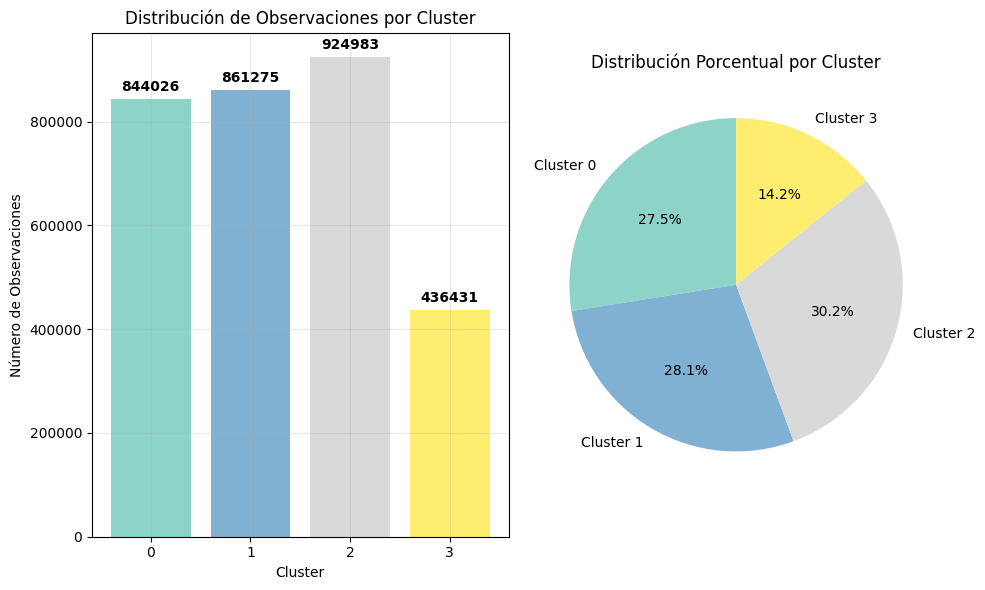

✅ Visualizaciones completadas!


In [204]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b43, save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

En el caso del coseno, conseguimos reducir a 4 los grupos perfectamente definidos, 2 con valores negativos (uno con valores mayores que el otro), y 2 con valores positivos (también uno con valores mayores que el otro).

La PC1 también obtiene el 99,8% de la varianza.

In [205]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [206]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b43_correlación_cruz__silver_transformations_pca_20251110_192002.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [207]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b43_correlación_cruz__silver_logs_20251110_192004.parquet
  Total de registros en log: 1


In [208]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 2.60 GB / 13.61 GB (21.6%)
[Inicio] Disco usado: 42.83 GB / 115.66 GB (37.0%)


[Final] Memoria usada: 2.61 GB / 13.61 GB (21.7%)
[Final] Disco usado: 42.83 GB / 115.66 GB (37.0%)



In [209]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 2.59 GB / 13.61 GB (21.5%)
[Inicio limpieza completa de memoria] Disco usado: 42.83 GB / 115.66 GB (37.0%)


[Final limpieza completa de memoria] Memoria usada: 2.59 GB / 13.61 GB (21.5%)
[Final limpieza completa de memoria] Disco usado: 42.83 GB / 115.66 GB (37.0%)



**B-4-4. Día del mes**

In [210]:
grupo_b44 = [
    "tpep_pickup_datetime_day",
    "tpep_dropoff_datetime_day"
]

grupo_nombre = "B44 Correlación cruzada (inicio vs final): day"

In [211]:
# gestión de metadatos
params = {
    "features": grupo_b44,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "B44 Correlaci\u00f3n cruzada (inicio vs final): day",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_day",
      "tpep_dropoff_datetime_day"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-10T19:20:23.189999",
  "model_version": "134c4445622e",
  "featureset_version": "B44 Correlaci\u00f3n cruzada (inicio vs final): day_134c4445622e",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [212]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_b44,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b44_correlación_cruz__silver_features_20251110_192024.parquet
  Registros: 3,066,715
  Columnas: 7


In [213]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_b44,
    group_name=grupo_nombre
)

- **Matriz de correlación**

In [214]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b44,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_b44,
    group_name = grupo_nombre,
    method = "spearman"
)


📊 ANÁLISIS DE CORRELACIÓN - B44 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAY
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - B44 Correlación cruzada (inicio vs final): day
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.999
Correlación máxima: 0.999
Correlación mínima: 0.999
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares



📊 ANÁLISIS DE CORRELACIÓN - B44 CORRELACIÓN CRUZADA (INICIO VS FINAL): DAY
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - B44 Correlación cruzada (inicio vs final): day
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.999
Correlación máxima: 0.999
Correlación mínima: 0.999
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


Para el día del mes, como todos los datos del dataset corresponden al mismo mes, tenemos una correlación máxima.

In [215]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [216]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
    spark=spark,
    format="json",
    group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "B44 Correlaci\u00f3n cruzada (inicio vs final): day",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_day": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 31.0,
      "mean": 16.409723107624934,
      "median": 17.0,
      "std": 8.702087135276848,
      "q25": 9.0,
      "q75": 24.0,
      "n_outliers_iqr": 0
    },
    "tpep_dropoff_datetime_day": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 31.0,
      "mean": 16.412145243363014,
      "median": 17.0,
      "std": 8.70255321746187,
      "q25": 9.0,
      "q75": 24.0,
      "n_outliers_iqr": 0
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.9987725349209049,
        "max_correlation": 0.9987725349209049,
        "min_correlation": 0.9987725349209049,
        "std_correlation": 0.0,
 

- **Análisis de VIF**

In [217]:
analyze_vif(ds_for_correlation_clean, grupo_b44)

                    Variable       VIF          Interpretacion
0   tpep_pickup_datetime_day  407.5937  Alta multicolinealidad
1  tpep_dropoff_datetime_day  407.5937  Alta multicolinealidad

=== Variables con VIF aceptable ===



[]


=== Variables con VIF no aceptable (>= 10) ===



['tpep_pickup_datetime_day', 'tpep_dropoff_datetime_day']

VIF confirma la muy alta correlación lineal entre ambas variables.

- **Clustering**

In [218]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_b44, num_clusters_a_probar)

plot_silhouette_scores(scores)

Para k = 2, la silueta media es: 0.7925
Para k = 3, la silueta media es: 0.7434
Para k = 4, la silueta media es: 0.7439
Para k = 5, la silueta media es: 0.7090
Para k = 6, la silueta media es: 0.7097
Para k = 7, la silueta media es: 0.7019
Para k = 8, la silueta media es: 0.7137


In [219]:
k_optimo = 2

In [220]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_b44,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['tpep_pickup_datetime_day', 'tpep_dropoff_datetime_day']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 117922426.0778

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1626325|
|1      |1440390|
+-------+-------+


⏱️ Tiempo de ejecución: 59.46 segundos
📊 Balance de clusters - Min: 1440390,  Max: 1626325, Std: 92967.50


In [221]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.7925485298372268,
  "wssse": 117922426.0777515,
  "cluster_sizes": [
    [
      1,
      1440390
    ],
    [
      0,
      1626325
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7925485298372268,
    "3": 0.7434326881324061,
    "4": 0.7439351403911234,
    "5": 0.7090479653846056,
    "6": 0.7097018143400639,
    "7": 0.7018944281841358,
    "8": 0.7137465217511665
  },
  "centers": [
    [
      23.486738505526265,
      23.483506064286043
    ],
    [
      8.41916008858712,
      8.427966731232514
    ]
  ]
}


In [222]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/b44_correlación_cruz__silver_clusters_20251110_193253.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [223]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_b44, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [224]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


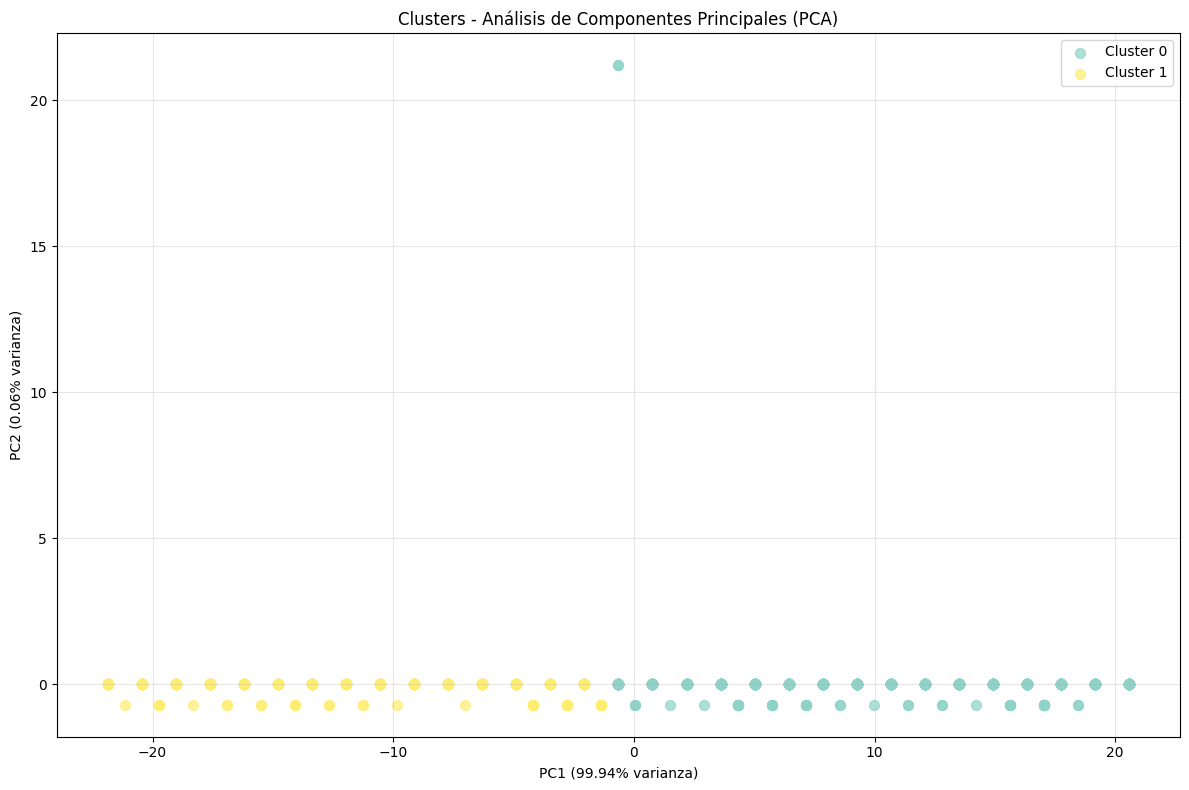

2. Perfiles de clusters...


3. Distribución de clusters...


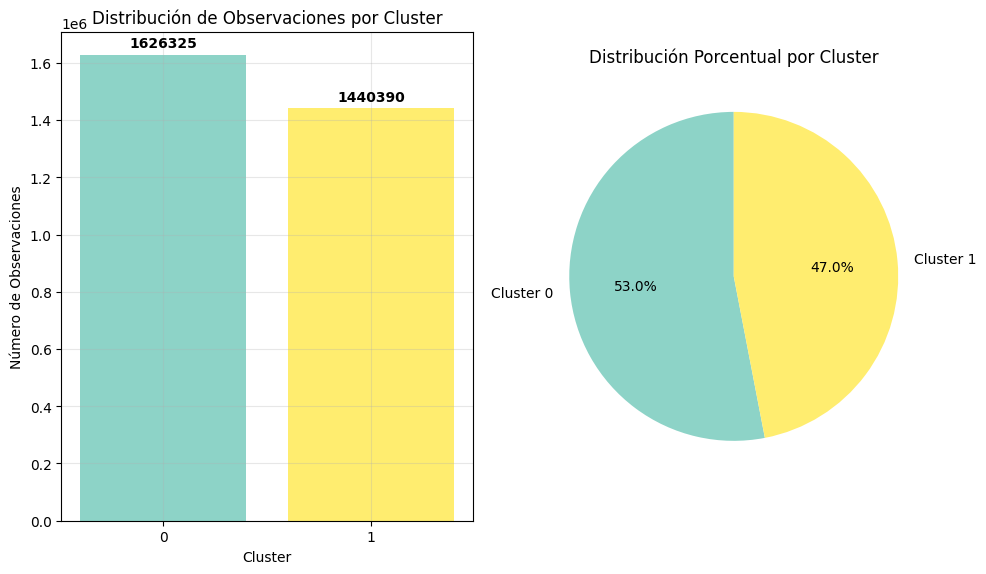

✅ Visualizaciones completadas!


In [225]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_b44,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Tenemos 2 clusters muy separados, especialmente en PC1 que obtiene más del 99.9% de la varianza. Ambos grupos son muy similares, la principal diferencia es que uno de ellos tiene unos valores medios superiores al otro.

La distinción entre ambos grupos, dado que todos los datos corresponden al mismo mes, se debe a una partición arbitraria de PCA poniendo la primera quincena del mes en un cluster (días 1 a 15) y la segunda en el otro cluster (días 16 a 31).

In [226]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [227]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/b44_correlación_cruz__silver_transformations_pca_20251110_193948.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [228]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/b44_correlación_cruz__silver_logs_20251110_193950.parquet
  Total de registros en log: 1


In [229]:
# limpia la memoria
ds_for_correlation_clean.unpersist()
ds_con_clusters.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, total_amount_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, fare_per_mile_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_dayofweek_sin: double, tpep_dropoff_datetime_dayofweek_cos: double, VendorID_encoded: int, store_and_fwd_flag_encoded: int, pickup_hour_hour_sin: double, pickup_hour_hour_cos: double, tip_score_encoded: double, trip_extra_cost_ratio_encoded: double, toll_indicator_encoded: int, clus

In [230]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
